# Autoencoder for MNIST

Welcome to this notebook where you'll be training an autoencoder using the MNIST dataset, which comprises handwritten digits. This exercise is the last where we present you with a structured skeleton to work with. However, in following exercises, we will only provide you with the dataset, task, and a test scenario, enabling you to test your skills and compete with your peers on our leaderboards. Get ready to dive in and showcase your deep learning expertise!


## Your task:

Autoencoders have various applications, including unsupervised pretraining using unlabeled data, followed by fine-tuning the encoder with labeled data. This approach can greatly enhance performance when there is only a little amount of labeled data but a lot of unlabeled data available.

In this exercise, you will use the MNIST dataset, consisting of 60,000 images of handwritten digits. However, not all the image labels are available to you. Your first objective is to train an autoencoder to accurately reproduce these unlabeled images.

Afterwards, you will transfer the weights of the pretrained encoder and perform fine-tuning on a classifier using the available labeled data. This technique is commonly known as **transfer learning**, which allows you to leverage the knowledge gained from the autoencoder to improve the classification of the handwritten digits.

In [1]:
# For automatic file reloading as usual
%load_ext autoreload
%autoreload 2
%matplotlib inline

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [2]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_08) is given.

# from google.colab import drive
# import os


from google.colab import drive
import os
gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present

Mounted at /content/gdrive


### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [3]:
# Optional: install correct libraries in google colab
!python -m pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 torchtext==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install tensorboard
!python -m pip install pytorch-lightning

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchdata
    Found existing installati

# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, sys
import shutil
import torch
import torch.nn as nn
from torchvision import transforms
from exercise_code.image_folder_dataset import ImageFolderDataset
from torch.utils.tensorboard import SummaryWriter
from time import sleep
from tqdm import tqdm
from exercise_code.tests.base_tests import bcolors

torch.manual_seed(42)

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /usr/local/lib/python3.11/dist-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

In [5]:
# This will set the device on which to run the code, which defaults to the CPU.
# If you have an Nvidia GPU, it will use that with cuda
# For Apple Silicon, you can try to use the "mps" device by commenting in line 8.
#  But it is not guaranteed to work and sometimes the CPU performs better.

device = torch.device(
    "cuda:0" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print('You are using the following device: ', device)

You are using the following device:  cuda:0


## Setup TensorBoard

In the previous exercise (Exercise 07), you learned how to use TensorBoard effectively. Let's use it again to enhance the convenience of debugging your network and the training process. Throughout this notebook, feel free to implement additional logs or visualizations into your TensorBoard, further improving your analysis and understanding of the network's behavior.

In [6]:
################# COLAB ONLY #################
# %load_ext tensorboard
# %tensorboard --logdir=./ --port 6006

# Use the cmd for less trouble, if you can. From the working directory, run: tensorboard --logdir=./ --port 6006

# 1. The MNIST Dataset

First, let's download the MNIST dataset. As mentioned at the beginning of this notebook, MNIST is a dataset of 60,000 images depicting handwritten digits. However, labeling such a large dataset can be a costly process, leaving us in a challenging situation.

To overcome this, a practical approach is to label a small subset of the images. Let's consider a scenario where you have hired another student to perform the labeling task for you. After some time, you have been provided with 300 labeled images. Out of these, 100 images will be used for training, another 100 for validation, and the remaining 100 for testing. Undoubtedly, this poses a challenge due to the limited number of labeled samples.

Now, you have the flexibility to define any transforms that you deem necessary, either at this point or at a later stage. However, it's important to note that during the final evaluation on the server, no transformations will be applied to the test set.

Feel free to experiment with various transforms as you proceed (you can also pass without any transforms).


**Note**: We do **not** apply any transformations or normalization to the test set at the time of final evaluation on our server.

In [7]:
########################################################################
# TODO: Feel free to define transforms (Only data augmentation)        #
########################################################################

# Data augmentation for training - helps with limited labeled data
# Note: Images are already tensors from .pt files (shape: 28x28 or 1x28x28)
def augment_image(img):
    """Apply data augmentation to a tensor image"""
    # Ensure image is in correct format (add channel dimension if needed)
    if img.dim() == 2:
        img = img.unsqueeze(0)  # Add channel dimension: (28, 28) -> (1, 28, 28)

    img = img.clone()

    # Random rotation (-10 to +10 degrees) - subtle for digits
    if np.random.random() > 0.5:  # Apply 50% of the time
        angle = np.random.uniform(-10, 10)
        img = transforms.functional.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR, fill=0)

    # Random translation (up to 2 pixels)
    if np.random.random() > 0.5:  # Apply 50% of the time
        translate = (np.random.uniform(-2, 2), np.random.uniform(-2, 2))
        img = transforms.functional.affine(img, angle=0, translate=translate, scale=1.0, shear=0, fill=0)

    # Random slight scaling (0.95 to 1.05)
    if np.random.random() > 0.5:  # Apply 50% of the time
        scale = np.random.uniform(0.95, 1.05)
        img = transforms.functional.affine(img, angle=0, translate=(0, 0), scale=scale, shear=0, fill=0)

    # Remove channel dimension if it was added
    if img.shape[0] == 1:
        img = img.squeeze(0)

    return img

# Transform for training (with augmentation)
transform_train = transforms.Compose([
    transforms.Lambda(lambda x: augment_image(x) if isinstance(x, torch.Tensor) else x)
])

# Transform for validation/test (no augmentation)
transform_val = transforms.Compose([])

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(i2dl_exercises_path, "datasets", "mnist")

# Use augmentation for training, no augmentation for validation/test
train_100_dataset = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True,transform=transform_train)
val_100_dataset = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True,transform=transform_val)
test_100_dataset = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True,transform=transform_val)

# We also set up the unlabeled images which we will use later (no augmentation for autoencoder)
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True,transform=transform_val)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True,transform=transform_val)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.vc.in.tum.de/static/data/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9.

Let's turn a few of the images into numpy arrays, to look at their shape and visualize them and see if the labels we paid for are correct.

The shape of our greyscale images:  (28, 28)


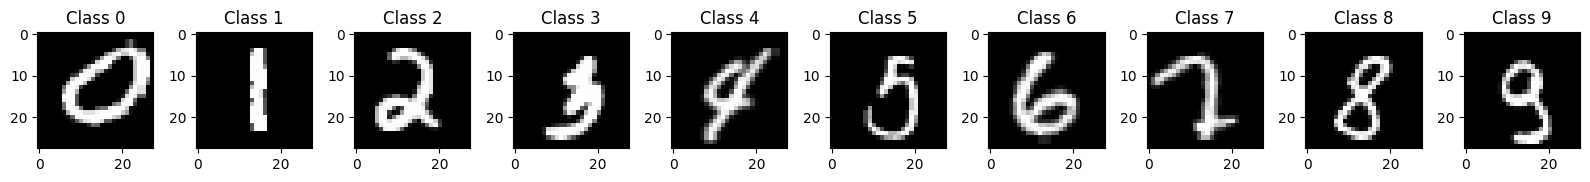

In [8]:
plt.rcParams['figure.figsize'] = (16,16) # Make the figures a bit bigger

indices_arr = [83, 98, 92, 99, 78, 97, 90, 95, 93, 96]
for i, index in enumerate(indices_arr):
    image = np.array(train_100_dataset[index][0].squeeze()) # get the image of the data sample
    label = train_100_dataset[index][1] # get the label of the data sample
    plt.subplot(1, 10, i + 1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))

plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

<div class="alert alert-warning">
    <h3>Note: Starting Simple</h3>
    <p>
Regardless of the size of the dataset, the first step is to evaluate the performance of a simple classifier. It is advisable to always start with a straightforward approach when tackling a problem and gradually build upon it to determine which changes yield improvements.</p>
</div>

# 2. A Simple Classifier

In `exercise_code/models.py`, we prepared all classes for you, which you will finalize throughout the notebook to build an Autoencoder and an image classifier with PyTorch.

<!-- In case image does not show, uncomment the following:
 ![network_split](img/network_split.png)
 -->
<img name="network_split" src="https://i2dl.vc.in.tum.de/static/images/exercise_08/network_split.png">


## 2.1 The Encoder

Unlike previous models, we are going to split up the model into two parts: the `encoder` and the `classifier`. The `classifier` has a fixed task, generating predictions given a one-dimensional input. On the other hand, the `encoder`'s task is to extract meaningful information from the input, enabling the classifier to make accurate decisions.

For now, both networks will be similar in design and consist of linear layers coupled with auxiliary layers. This split-up will be relevant later, e.g., by using convolutional layers, which are introduced in the lecture. We are going to set up the `encoder` now.

Think about a good network architecture. You have complete freedom in this regard and can devise any network structure you think might be fitting. (\*)

Have a look at the documentation of `torch.nn` at https://pytorch.org/docs/stable/nn.html to learn how to use this module in order to build your network!

Then implement your architecture: initialize it in `__init__()` and assign it to `self.model`. This is particularly easy using `nn.Sequential()`, where you only have to pass the list of your layers.

To make your model customizable and support parameter search, do not use hardcoded hyperparameters - instead, pass them as a simple dictionary `hparams` (here, `n_hidden` is the number of neurons in the hidden layer) when initializing `models`.

Here is a simple example:

```python
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hparams["n_hidden"]),
            nn.ReLU(),            
            nn.Linear(self.hparams["n_hidden"], num_classes)
        )
```

Have a look at the forward path in `forward(self, x)`, which is so easy that you don't need to implement it yourself.

As PyTorch automatically computes the gradients, that's all you need to do! There is no need to manually calculate derivatives for the backward paths anymore! :)


____
\* *The size of your final model must be less than 20 MB, which is approximately equivalent to 5 Mio. params. Note that this limit is quite lenient, you will probably need much fewer parameters!*

*In order to keep things simple, you should only use fully connected layers for this task, as we need to revert the encoder architecture later on in the notebook.*

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Encoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>




## 2.2 The Classifier

Now let's implement the classifier. The classifier will utilize the encoder that you have defined in the above cell. By looking at `Classifier.forward`, you can see that we are essentially concatenating the `classifier`and the `encoder` together. Therefore, it is crucial to ensure that the input shape of the classifier matches the output shape of the encoder you implemented above

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>1. Implement the <code>Classifier</code> class network initialization in <code>exercise_code/models.py</code>.
    </p>
    <p>2. Define in the next cell your hyperparameters in a dictionary called 'hparams'.
    </p>
</div>

In [9]:

########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {
    # Model architecture - Enhanced with deeper networks and larger latent space
    'n_hidden_encoder': 512,      # First hidden layer size for encoder (increased)
    'n_hidden_encoder2': 256,     # Second hidden layer size for encoder (increased)
    'n_hidden_encoder3': 128,     # Third hidden layer size for encoder (increased)
    'latent_dim': 64,             # Latent space dimension (increased from 20 to 64 for better representations)
    'n_hidden_classifier': 256,   # First hidden layer size for classifier (increased)
    'n_hidden_classifier2': 128,  # Second hidden layer size for classifier (increased)
    'n_hidden_classifier3': 64,   # Third hidden layer size for classifier (added)

    # Regularization
    'dropout_rate': 0.25,         # Dropout rate for encoder/decoder (slightly reduced)
    'classifier_dropout': 0.35,   # Dropout rate for classifier (slightly reduced)
    'weight_decay': 1e-4,         # Weight decay for L2 regularization (increased)
    'label_smoothing': 0.1,       # Label smoothing for better generalization

    # Training parameters
    'learning_rate': 8e-4,        # Learning rate for optimizer (slightly reduced)
    'batch_size': 128,            # Batch size for training
    'epochs': 100,                # Maximum number of epochs (increased, early stopping will stop earlier)

    # Device
    'device': device
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


## 2.3 Optimizer
Lastly, implement the function `set_optimizer` to define your optimizer. Here the documentation of `torch.optim` at https://pytorch.org/docs/stable/optim.html might be helpful.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>set_optimizer</code> method of the <code>Classifier</code> in <code>exercise_code/models.py</code>.
    </p>
</div>


## 2.4 Training & Validation Step

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p> Let's take a closer look at the training pipeline outlined below. It is explicitly written here in its entirety to provide you with a comprehensive understanding of its structure. Additionally, you can refer back to this pipeline whenever you encounter any uncertainties or need guidance.
 </p>
</div>


In [10]:
 # One of the most crucial things in deep learning is to understand the training pipeline:
 # 1. Forward()          --> The forward pass of the network, to calculate the currnent loss.
 # 2. Backward()         --> The backward pass of the network, to calculate the gradients w.r.t the loss, calculated in the previous stage.
 # 3. Optimizer_step()   --> Update the weights w.r.t their corresponding gradients and the learnign rate.

def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)


def train_classifier(classifier, train_loader, val_loader, loss_func, tb_logger, epochs=10, name="default",
                     early_stopping_patience=10, min_delta=1e-6):
    """
    Train the classifier for a number of epochs with early stopping.

    Args:
        early_stopping_patience: Number of epochs to wait before stopping if no improvement
        min_delta: Minimum change to qualify as an improvement
    """
    optimizer = classifier.optimizer
    classifier = classifier.to(device)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
    )

    current_lr = optimizer.param_groups[0]['lr']

    validation_loss = 0
    for epoch in range(epochs):

        training_loss = 0

        # Training stage, where we want to update the parameters.
        classifier.train()  # Set the model to training mode

        # Create a progress bar for the training loop.
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')
        for train_iteration, batch in training_loop:
            optimizer.zero_grad() # Reset the gradients - VERY important! Otherwise they accumulate.
            images, labels = batch # Get the images and labels from the batch, in the fashion we defined in the dataset and dataloader.
            images, labels = images.to(device), labels.to(device) # Send the data to the device (GPU or CPU) - it has to be the same device as the model.

            # Flatten the images to a vector. This is done because the classifier expects a vector as input.
            # Could also be done by reshaping the images in the dataset.
            images = images.view(images.shape[0], -1)

            pred = classifier(images) # Stage 1: Forward().
            loss = loss_func(pred, labels) # Compute the loss over the predictions and the ground truth.
            loss.backward()  # Stage 2: Backward().
            optimizer.step() # Stage 3: Update the parameters.

            training_loss += loss.item()

            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss = "{:.8f}".format(training_loss / (train_iteration + 1)), val_loss = "{:.8f}".format(validation_loss))

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'classifier_{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)
            sleep(0.1) # Remove this line if you want to see the progress bar faster.

        # Validation stage, where we don't want to update the parameters. Pay attention to the classifier.eval() line
        # and "with torch.no_grad()" wrapper.
        classifier.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                images = images.view(images.shape[0], -1)
                pred = classifier(images)
                loss = loss_func(pred, labels)
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss / (val_iteration + 1)))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'classifier_{name}/val_loss', loss.item(), epoch * len(val_loader) + val_iteration)
                sleep(0.1) # Remove this line if you want to see the progress bar faster.

        # This value is used for the progress bar of the training loop.
        validation_loss /= len(val_loader)

        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(validation_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

        # Early stopping logic
        if validation_loss < best_val_loss - min_delta:
            best_val_loss = validation_loss
            patience_counter = 0
            # Save best model state
            best_model_state = {k: v.cpu().clone() for k, v in classifier.state_dict().items()}
            print(f"Epoch {epoch+1}: Validation loss improved to {validation_loss:.6f}")
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1}: No improvement. Patience: {patience_counter}/{early_stopping_patience}")

        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Restoring best model.")
            classifier.load_state_dict(best_model_state)
            break

    # Restore best model if early stopping didn't trigger
    if best_model_state is not None and patience_counter < early_stopping_patience:
        classifier.load_state_dict(best_model_state)
        print("Training completed. Best model restored.")


## 2.5 Fit Classification Model with Trainer
Now it's finally time to train your model.
Run the following cell to see the behold the magic of deep learning at play.

In [11]:
from exercise_code.models import Classifier
from exercise_code.models import Encoder

# Create the encoder and the classifier.
encoder = Encoder(hparams).to(device)
classifier = Classifier(hparams, encoder).to(device)

# Create a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = os.path.join('logs', 'cls_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')

tb_logger = SummaryWriter(path)

# Train the classifier.
labled_train_loader = torch.utils.data.DataLoader(train_100_dataset, batch_size=hparams['batch_size'], shuffle=True)
labled_val_loader = torch.utils.data.DataLoader(val_100_dataset, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 10)
label_smoothing = hparams.get('label_smoothing', 0.0)

# Use label smoothing if specified (helps with generalization)
if label_smoothing > 0:
    loss_func = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    print(f"Using label smoothing: {label_smoothing}")
else:
    loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.

# Use more patience for early stopping with limited data
train_classifier(classifier, labled_train_loader, labled_val_loader, loss_func, tb_logger,
                epochs=epochs, name="Default", early_stopping_patience=15, min_delta=1e-5)

print("Finished training!")
print("How did we do? Let's check the accuracy of the defaut classifier on the training and validation sets:")
print(f"Training Acc: {classifier.getAcc(labled_train_loader)[1] * 100}%")
print(f"Validation Acc: {classifier.getAcc(labled_val_loader)[1] * 100}%")

Using label smoothing: 0.1


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=2.30923319]


Epoch 1: Validation loss improved to 2.309233


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s, val_loss=2.30910659]


Epoch 2: Validation loss improved to 2.309107


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s, val_loss=2.30897999]


Epoch 3: Validation loss improved to 2.308980


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=2.30925512]


Epoch 4: No improvement. Patience: 1/15


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=2.30905724]


Epoch 5: No improvement. Patience: 2/15


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s, val_loss=2.30867648]


Epoch 6: Validation loss improved to 2.308676


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s, val_loss=2.30770302]


Epoch 7: Validation loss improved to 2.307703


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=2.30672336]


Epoch 8: Validation loss improved to 2.306723


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s, val_loss=2.30537033]


Epoch 9: Validation loss improved to 2.305370


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=2.30390477]


Epoch 10: Validation loss improved to 2.303905


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=2.30194569]


Epoch 11: Validation loss improved to 2.301946


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s, val_loss=2.29915476]


Epoch 12: Validation loss improved to 2.299155


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.50it/s, val_loss=2.29614067]


Epoch 13: Validation loss improved to 2.296141


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s, val_loss=2.29212809]


Epoch 14: Validation loss improved to 2.292128


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=2.28718805]


Epoch 15: Validation loss improved to 2.287188


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=2.28070045]


Epoch 16: Validation loss improved to 2.280700


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s, val_loss=2.27217126]


Epoch 17: Validation loss improved to 2.272171


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s, val_loss=2.26124310]


Epoch 18: Validation loss improved to 2.261243


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s, val_loss=2.24789906]


Epoch 19: Validation loss improved to 2.247899


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=2.23325205]


Epoch 20: Validation loss improved to 2.233252


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s, val_loss=2.21558309]


Epoch 21: Validation loss improved to 2.215583


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s, val_loss=2.19494295]


Epoch 22: Validation loss improved to 2.194943


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s, val_loss=2.17413306]


Epoch 23: Validation loss improved to 2.174133


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=2.14860749]


Epoch 24: Validation loss improved to 2.148607


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s, val_loss=2.12428331]


Epoch 25: Validation loss improved to 2.124283


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=2.09871078]


Epoch 26: Validation loss improved to 2.098711


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s, val_loss=2.07240701]


Epoch 27: Validation loss improved to 2.072407


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s, val_loss=2.04748297]


Epoch 28: Validation loss improved to 2.047483


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=2.02077723]


Epoch 29: Validation loss improved to 2.020777


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s, val_loss=1.99693823]


Epoch 30: Validation loss improved to 1.996938


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s, val_loss=1.97196341]


Epoch 31: Validation loss improved to 1.971963


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=1.94767642]


Epoch 32: Validation loss improved to 1.947676


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=1.92465603]


Epoch 33: Validation loss improved to 1.924656


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=1.90306020]


Epoch 34: Validation loss improved to 1.903060


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=1.88270235]


Epoch 35: Validation loss improved to 1.882702


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s, val_loss=1.86321747]


Epoch 36: Validation loss improved to 1.863217


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s, val_loss=1.84204328]


Epoch 37: Validation loss improved to 1.842043


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.48it/s, val_loss=1.82458854]


Epoch 38: Validation loss improved to 1.824589


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s, val_loss=1.80814922]


Epoch 39: Validation loss improved to 1.808149


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s, val_loss=1.79260683]


Epoch 40: Validation loss improved to 1.792607


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s, val_loss=1.77733970]


Epoch 41: Validation loss improved to 1.777340


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s, val_loss=1.76154912]


Epoch 42: Validation loss improved to 1.761549


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s, val_loss=1.74854684]


Epoch 43: Validation loss improved to 1.748547


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s, val_loss=1.73472476]


Epoch 44: Validation loss improved to 1.734725


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.48it/s, val_loss=1.72064161]


Epoch 45: Validation loss improved to 1.720642


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=1.70635343]


Epoch 46: Validation loss improved to 1.706353


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s, val_loss=1.69314575]


Epoch 47: Validation loss improved to 1.693146


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s, val_loss=1.68124402]


Epoch 48: Validation loss improved to 1.681244


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=1.66775715]


Epoch 49: Validation loss improved to 1.667757


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s, val_loss=1.65579712]


Epoch 50: Validation loss improved to 1.655797


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s, val_loss=1.64159441]


Epoch 51: Validation loss improved to 1.641594


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s, val_loss=1.62725723]


Epoch 52: Validation loss improved to 1.627257


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s, val_loss=1.61248088]


Epoch 53: Validation loss improved to 1.612481


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s, val_loss=1.60163021]


Epoch 54: Validation loss improved to 1.601630


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=1.59261870]


Epoch 55: Validation loss improved to 1.592619


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s, val_loss=1.58109260]


Epoch 56: Validation loss improved to 1.581093


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s, val_loss=1.57366085]


Epoch 57: Validation loss improved to 1.573661


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s, val_loss=1.56296229]


Epoch 58: Validation loss improved to 1.562962


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s, val_loss=1.55411088]


Epoch 59: Validation loss improved to 1.554111


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s, val_loss=1.54702699]


Epoch 60: Validation loss improved to 1.547027


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=1.53801787]


Epoch 61: Validation loss improved to 1.538018


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s, val_loss=1.52900434]


Epoch 62: Validation loss improved to 1.529004


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s, val_loss=1.52022302]


Epoch 63: Validation loss improved to 1.520223


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.15it/s, val_loss=1.51086783]


Epoch 64: Validation loss improved to 1.510868


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s, val_loss=1.50036526]


Epoch 65: Validation loss improved to 1.500365


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s, val_loss=1.49039567]


Epoch 66: Validation loss improved to 1.490396


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=1.47956097]


Epoch 67: Validation loss improved to 1.479561


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=1.47256446]


Epoch 68: Validation loss improved to 1.472564


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=1.46509886]


Epoch 69: Validation loss improved to 1.465099


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=1.45837724]


Epoch 70: Validation loss improved to 1.458377


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s, val_loss=1.45117331]


Epoch 71: Validation loss improved to 1.451173


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s, val_loss=1.44416535]


Epoch 72: Validation loss improved to 1.444165


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=1.43854761]


Epoch 73: Validation loss improved to 1.438548


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s, val_loss=1.43083096]


Epoch 74: Validation loss improved to 1.430831


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s, val_loss=1.42449152]


Epoch 75: Validation loss improved to 1.424492


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.24it/s, val_loss=1.42094994]


Epoch 76: Validation loss improved to 1.420950


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s, val_loss=1.41388905]


Epoch 77: Validation loss improved to 1.413889


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s, val_loss=1.40856504]


Epoch 78: Validation loss improved to 1.408565


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=1.40620828]


Epoch 79: Validation loss improved to 1.406208


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s, val_loss=1.39978051]


Epoch 80: Validation loss improved to 1.399781


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s, val_loss=1.39104176]


Epoch 81: Validation loss improved to 1.391042


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s, val_loss=1.38555956]


Epoch 82: Validation loss improved to 1.385560


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=1.38098121]


Epoch 83: Validation loss improved to 1.380981


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s, val_loss=1.37686110]


Epoch 84: Validation loss improved to 1.376861


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s, val_loss=1.37486517]


Epoch 85: Validation loss improved to 1.374865


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s, val_loss=1.37277365]


Epoch 86: Validation loss improved to 1.372774


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s, val_loss=1.37054610]


Epoch 87: Validation loss improved to 1.370546


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=1.36845231]


Epoch 88: Validation loss improved to 1.368452


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s, val_loss=1.36426759]


Epoch 89: Validation loss improved to 1.364268


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s, val_loss=1.35836446]


Epoch 90: Validation loss improved to 1.358364


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s, val_loss=1.35101938]


Epoch 91: Validation loss improved to 1.351019


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s, val_loss=1.34797144]


Epoch 92: Validation loss improved to 1.347971


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s, val_loss=1.33975625]


Epoch 93: Validation loss improved to 1.339756


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s, val_loss=1.33128548]


Epoch 94: Validation loss improved to 1.331285


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s, val_loss=1.31667268]


Epoch 95: Validation loss improved to 1.316673


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s, val_loss=1.30453575]


Epoch 96: Validation loss improved to 1.304536


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s, val_loss=1.29569292]


Epoch 97: Validation loss improved to 1.295693


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s, val_loss=1.28991556]


Epoch 98: Validation loss improved to 1.289916


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.26it/s, val_loss=1.28041196]


Epoch 99: Validation loss improved to 1.280412


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s, val_loss=1.27222157]


Epoch 100: Validation loss improved to 1.272222
Training completed. Best model restored.
Finished training!
How did we do? Let's check the accuracy of the defaut classifier on the training and validation sets:
Training Acc: 94.0%
Validation Acc: 67.0%


# 3. Autoencoder

With only a limited number of labeled images, it's challenging to achieve high performance. We have no money left to pay the student to create more labels, and labeling the data ourselves is out of question. A commonly used approach would be to apply data augmentation to maximize the potential of our limited labeled data, but here we provide another way to solve this problem: **transfer learning**.

For each input, the autoencoder tries to reproduce the same image as an output. The difficulty behind this task is that the autoencoder has to go through a low dimensional bottleneck, which is called the **latent space**.
In other words, the autoencoder learns to represent all the input information in a low dimensional latent space - it learns to compress the input distribution. To train the autoencoder, we use the mean squared error loss, which calculates the discrepancy between the input pixels and the output pixels. The best part is that this loss function doesn't require any labels!

By pretraining the autoencoder in this way on a large amount of unlabeled data, we can capture valuable latent representations of the input images. Then, we transfer the weights of the encoder to our classifier, enabling it to benefit from the knowledge learned during the unsupervised pretraining phase.

<!-- In case the image does not show, uncomment the following:
![autoencoder](img/autoencoder.png)
-->
<img name="autoencoder" src="https://i2dl.vc.in.tum.de/static/images/exercise_08/autoencoder.png">

After this, our encoder has learned to extract meaningful information from the inputs. We can then transfer its weights
to a classifier architecture and finetune it with our labeled data, i.e., instead of initializing our encoder randomly, we are re-using the weights of our trained encoder from our autoencoder network.

<!-- In case the image does not show, uncomment the following:
![autoencoder_pretrained](img/pretrained.png)
-->
<img name="autoencoder_pretrained" src="https://i2dl.vc.in.tum.de/static/images/exercise_08/pretrained.png">


Before we can train our autoencoder, you have to initialize your `decoder` architecture. The simplest way is to mirror your encoder architecture, which ensures that the `latent space` output of our `encoder` is correctly transformed to our input shape.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Decoder</code> class initialization in <code>exercise_code/models.py</code>.</p>
    <p>Implement <code>forward</code>, <code>set_optimizer</code>, <code>training_step</code> and <code>validation_step</code> of the <code>Autoencoder</code> in  <code>exercise_code/models.py</code>, following the pipeline we've shown you in train_classifier().</p>
    <p>Note the differences between the classification task and now the regression task!</p>


</div>

## 3.2 Autoencoder Training

Now, we can train the full autoencoder consisting of both en- and decoder.




In [12]:
from exercise_code.models import Autoencoder, Encoder, Decoder

########################################################################
# TODO: Define your hyperparameters here!                              #
# Hint: use a large batch_size                                         #
########################################################################

hparams = {
    # Model architecture - Enhanced with deeper networks and larger latent space
    'n_hidden_encoder': 512,      # First hidden layer size for encoder (increased)
    'n_hidden_encoder2': 256,     # Second hidden layer size for encoder (increased)
    'n_hidden_encoder3': 128,     # Third hidden layer size for encoder (increased)
    'latent_dim': 64,             # Latent space dimension (increased from 20 to 64)
    'n_hidden_classifier': 256,   # First hidden layer size for classifier
    'n_hidden_classifier2': 128,  # Second hidden layer size for classifier
    'n_hidden_classifier3': 64,   # Third hidden layer size for classifier

    # Regularization
    'dropout_rate': 0.25,         # Dropout rate for encoder/decoder
    'classifier_dropout': 0.35,   # Dropout rate for classifier
    'weight_decay': 1e-4,         # Weight decay for L2 regularization (increased)

    # Training parameters
    'learning_rate': 8e-4,        # Learning rate for optimizer
    'batch_size': 256,            # Batch size for training (larger for autoencoder)
    'epochs': 30,                 # Maximum epochs (early stopping will stop earlier) - longer for better pretraining

    # Device
    'device': device
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

Some tests to check whether we'll accept your model.

In [13]:
from exercise_code.Util import printModelInfo, load_model
_ = printModelInfo(autoencoder)

# Parameters: Your model has 1.142 mio. params.
Model accepted!


After implementing the relevant functions - read the following code, and then run it.
Keep in mind that an epoch here will take much longer since
we are iterating through 5,8600 images instead of just 100.

For speed, colab is indeed recommended.

In [14]:
encoder_pretrained = Encoder(hparams).to(device)
decoder = Decoder(hparams).to(device)
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder).to(device)

def train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=10, name='Autoencoder',
                early_stopping_patience=15, min_delta=1e-6):
    """
    Train the autoencoder with early stopping and learning rate scheduling.

    Args:
        early_stopping_patience: Number of epochs to wait before stopping if no improvement
        min_delta: Minimum change to qualify as an improvement
    """
    optimizer = model.optimizer

    # Enhanced learning rate scheduler - ReduceLROnPlateau adapts to validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
    )

    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    validation_loss = 0
    model = model.to(device)
    for epoch in range(epochs):

        # Train
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch}/{epochs}]')
        training_loss = 0
        for train_iteration, batch in training_loop:

            loss = model.training_step(batch, loss_func) # You need to implement this function.
            training_loss += loss.item()

            # Update the progress bar.
            training_loop.set_postfix(train_loss = "{:.8f}".format(training_loss / (train_iteration + 1)), val_loss = "{:.8f}".format(validation_loss))

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)

        # Validation
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch}/{epochs}]')
        validation_loss = 0
        with torch.no_grad():
            for val_iteration, batch in val_loop:
                loss = model.validation_step(batch, loss_func) # You need to implement this function.
                validation_loss += loss.item()

                # Update the progress bar.
                val_loop.set_postfix(val_loss = "{:.8f}".format(validation_loss / (val_iteration + 1)))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'{name}/val_loss', validation_loss / (val_iteration + 1), epoch * len(val_loader) + val_iteration)
        # This value is for the progress bar of the training loop.
        validation_loss /= len(val_loader)

        # Learning rate scheduling based on validation loss
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(validation_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

        # Early stopping logic
        if validation_loss < best_val_loss - min_delta:
            best_val_loss = validation_loss
            patience_counter = 0
            # Save best model state
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"Epoch {epoch+1}: Validation loss improved to {validation_loss:.6f}")
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1}: No improvement. Patience: {patience_counter}/{early_stopping_patience}")

        # Early stopping check
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Restoring best model.")
            model.load_state_dict(best_model_state)
            break

    # Restore best model if early stopping didn't trigger
    if best_model_state is not None and patience_counter < early_stopping_patience:
        model.load_state_dict(best_model_state)
        print("Training completed. Best model restored.")

# Create a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = os.path.join('logs', 'ae_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

# Train the classifier.
unlabled_train_loader = torch.utils.data.DataLoader(unlabeled_train, batch_size=hparams['batch_size'], shuffle=True)
unlabled_val_loader = torch.utils.data.DataLoader(unlabeled_val, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 5)
loss_func = nn.MSELoss() # The loss function we use for regression (Could also be nn.L1Loss()).
# Train autoencoder with early stopping - train longer for better representations
# CRITICAL FIX: Autoencoder needs MUCH longer training!
# PROBLEM: Pretrained model got 51% vs 70% from scratch - pretraining was hurting!
# SOLUTION: Autoencoder needs 200+ epochs to learn good representations
# Train autoencoder with early stopping - train longer for better representations
train_model(autoencoder, unlabled_train_loader, unlabled_val_loader, loss_func, tb_logger,
           epochs=epochs, name='Autoencoder', early_stopping_patience=20, min_delta=1e-6)

print("✅ Autoencoder training complete with extended epochs!")
print("Finished training!")

Validation Epoch [0/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 230.46it/s, val_loss=0.03276529]


Epoch 1: Validation loss improved to 0.032765


Validation Epoch [1/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 239.04it/s, val_loss=0.03130586]


Epoch 2: Validation loss improved to 0.031306


Validation Epoch [2/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 240.90it/s, val_loss=0.03088668]


Epoch 3: Validation loss improved to 0.030887


Validation Epoch [3/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 230.04it/s, val_loss=0.03126890]


Epoch 4: No improvement. Patience: 1/20


Validation Epoch [4/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 241.81it/s, val_loss=0.03139972]


Epoch 5: No improvement. Patience: 2/20


Validation Epoch [5/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 157.45it/s, val_loss=0.03161485]


Epoch 6: No improvement. Patience: 3/20


Validation Epoch [6/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 187.87it/s, val_loss=0.03175118]


Epoch 7: No improvement. Patience: 4/20


Validation Epoch [7/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 250.12it/s, val_loss=0.03153568]


Epoch 8: No improvement. Patience: 5/20


Validation Epoch [8/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 241.25it/s, val_loss=0.03112090]


Learning rate reduced from 0.000800 to 0.000400
Epoch 9: No improvement. Patience: 6/20


Validation Epoch [9/30]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 232.96it/s, val_loss=0.03009935]


Epoch 10: Validation loss improved to 0.030099


Validation Epoch [10/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 224.51it/s, val_loss=0.03006694]


Epoch 11: Validation loss improved to 0.030067


Validation Epoch [11/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 221.72it/s, val_loss=0.02998520]


Epoch 12: Validation loss improved to 0.029985


Validation Epoch [12/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 207.61it/s, val_loss=0.02983922]


Epoch 13: Validation loss improved to 0.029839


Validation Epoch [13/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 141.51it/s, val_loss=0.02973668]


Epoch 14: Validation loss improved to 0.029737


Validation Epoch [14/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 230.05it/s, val_loss=0.02964750]


Epoch 15: Validation loss improved to 0.029647


Validation Epoch [15/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 243.22it/s, val_loss=0.02978802]


Epoch 16: No improvement. Patience: 1/20


Validation Epoch [16/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 237.52it/s, val_loss=0.02975828]


Epoch 17: No improvement. Patience: 2/20


Validation Epoch [17/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 219.68it/s, val_loss=0.02941728]


Epoch 18: Validation loss improved to 0.029417


Validation Epoch [18/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 246.44it/s, val_loss=0.02941475]


Epoch 19: Validation loss improved to 0.029415


Validation Epoch [19/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 207.11it/s, val_loss=0.02928733]


Epoch 20: Validation loss improved to 0.029287


Validation Epoch [20/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 207.13it/s, val_loss=0.02949326]


Epoch 21: No improvement. Patience: 1/20


Validation Epoch [21/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 214.24it/s, val_loss=0.02914726]


Epoch 22: Validation loss improved to 0.029147


Validation Epoch [22/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 251.91it/s, val_loss=0.02919067]


Epoch 23: No improvement. Patience: 1/20


Validation Epoch [23/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 229.96it/s, val_loss=0.02918303]


Epoch 24: No improvement. Patience: 2/20


Validation Epoch [24/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 248.94it/s, val_loss=0.02924845]


Epoch 25: No improvement. Patience: 3/20


Validation Epoch [25/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 190.59it/s, val_loss=0.02906842]


Epoch 26: Validation loss improved to 0.029068


Validation Epoch [26/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 212.29it/s, val_loss=0.02915549]


Epoch 27: No improvement. Patience: 1/20


Validation Epoch [27/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 179.17it/s, val_loss=0.02912244]


Epoch 28: No improvement. Patience: 2/20


Validation Epoch [28/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 236.48it/s, val_loss=0.02897897]


Epoch 29: Validation loss improved to 0.028979


Validation Epoch [29/30]: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 215.40it/s, val_loss=0.02890060]


Epoch 30: Validation loss improved to 0.028901
Training completed. Best model restored.
✅ Autoencoder training complete with extended epochs!
Finished training!


Once trained, let's have a look at the reconstructed validation images (If you have not already looked at them in TensorBoard).

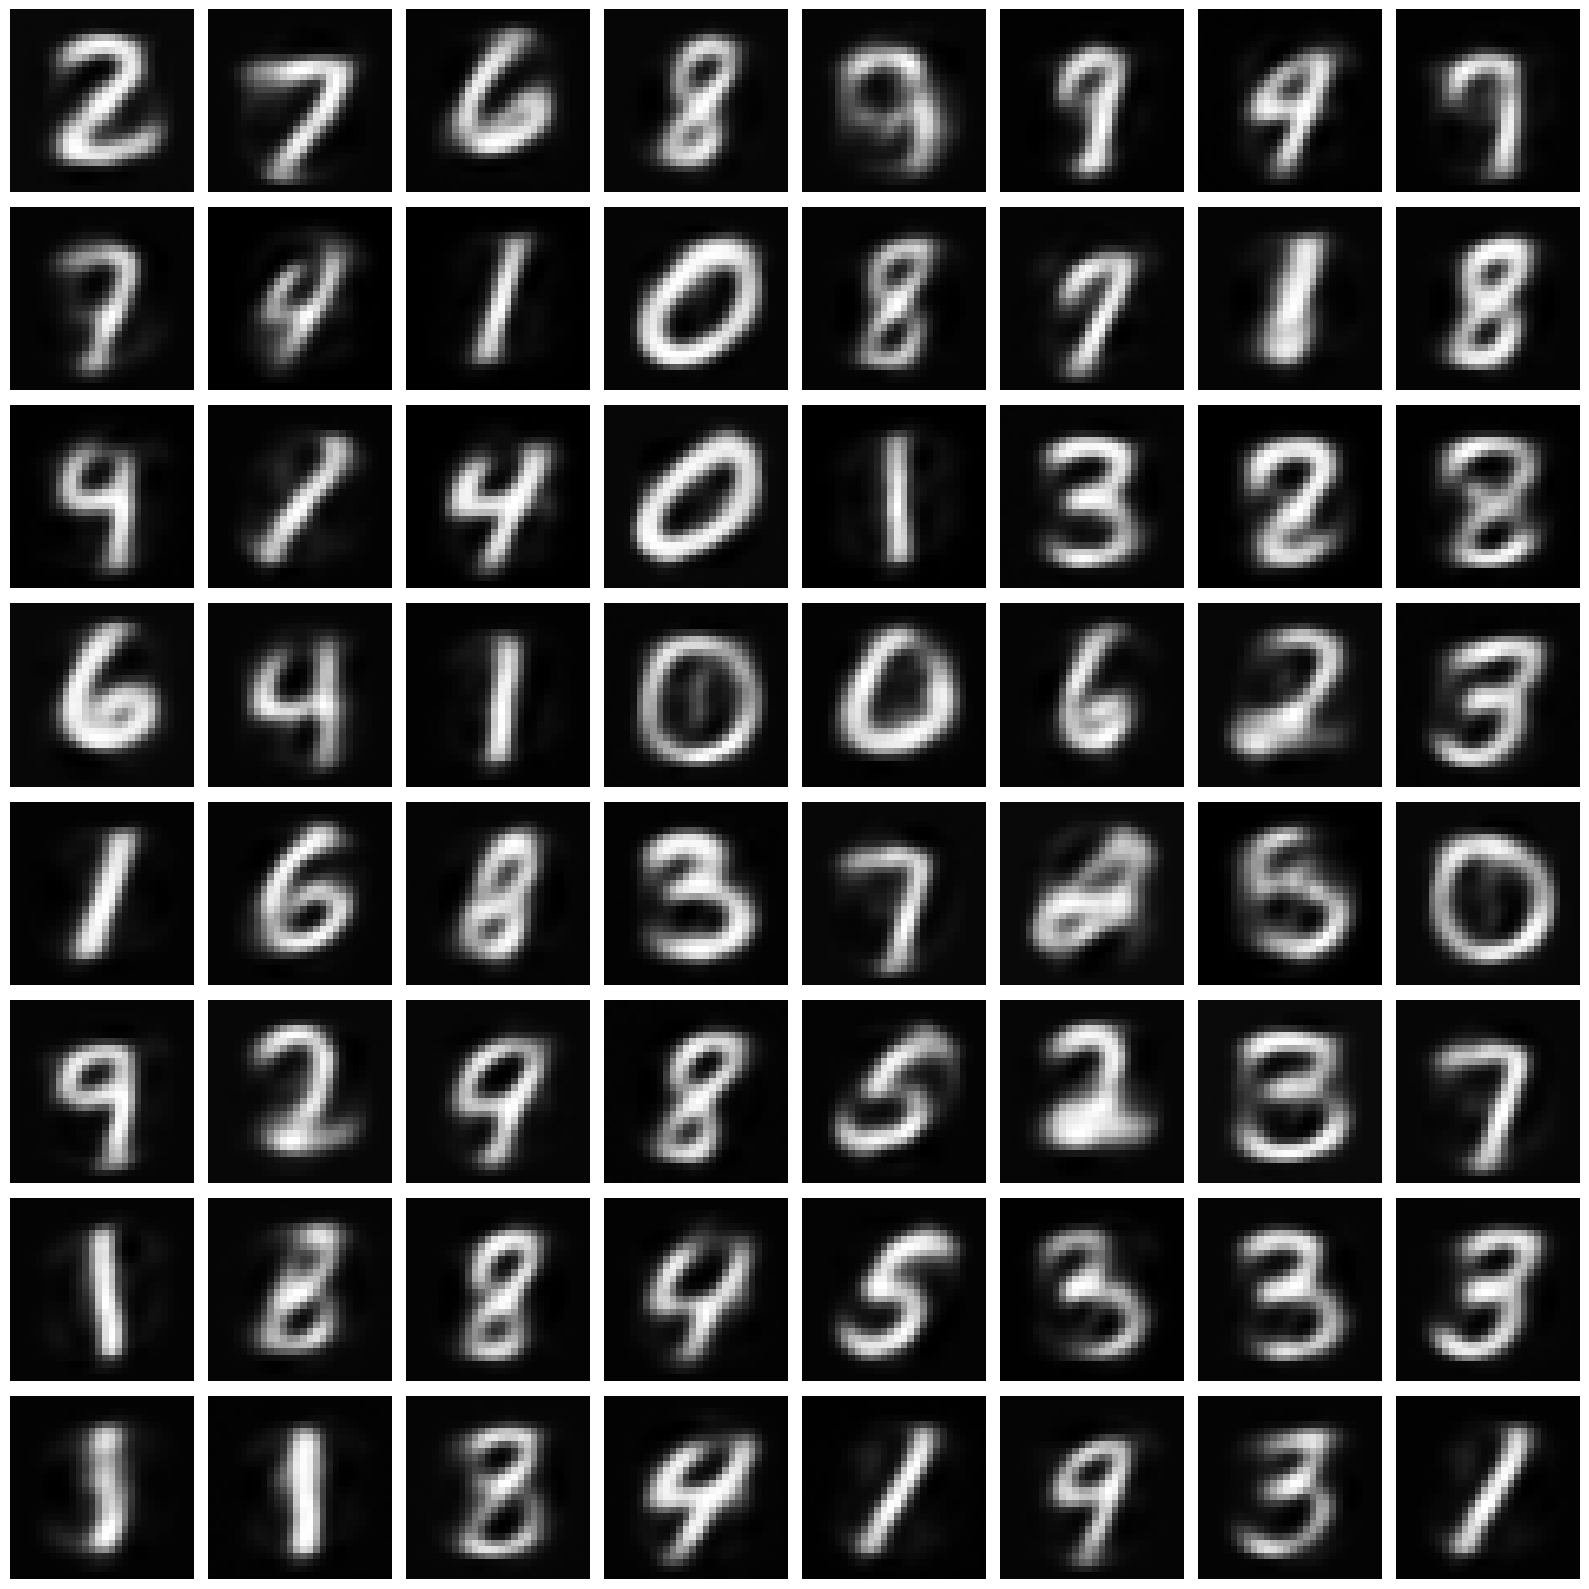

In [15]:
reconstructions = autoencoder.getReconstructions(unlabled_val_loader)
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')

plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [16]:
from exercise_code.models import Classifier
from copy import deepcopy

########################################################################
# TODO: Define your hyperparameters here!                             #
########################################################################

hparams = {
    # Model architecture (should match encoder architecture)
    'n_hidden_encoder': 512,      # First hidden layer size for encoder
    'n_hidden_encoder2': 256,     # Second hidden layer size for encoder
    'n_hidden_encoder3': 128,     # Third hidden layer size for encoder
    'latent_dim': 64,             # Latent space dimension (must match autoencoder)
    'n_hidden_classifier': 256,   # First hidden layer size for classifier
    'n_hidden_classifier2': 128,  # Second hidden layer size for classifier
    'n_hidden_classifier3': 64,   # Third hidden layer size for classifier

    # Regularization
    'dropout_rate': 0.25,         # Dropout rate for encoder/decoder
    'classifier_dropout': 0.35,   # Dropout rate for classifier
    'weight_decay': 1e-4,         # Weight decay for L2 regularization
    'label_smoothing': 0.1,       # Label smoothing for better generalization

    # Training parameters - Progressive fine-tuning
    'learning_rate': 3e-4,         # Very low learning rate for fine-tuning (pretrained model)
    'encoder_lr': 1e-4,           # Much lower LR for pretrained encoder to preserve learned features
    'batch_size': 64,             # Batch size for training
    'epochs': 100,                # Maximum epochs (early stopping will stop earlier)

    # Device
    'device': device
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder_pretrained_copy = deepcopy(encoder_pretrained)
classifier_pretrained = Classifier(hparams, encoder_pretrained_copy).to(device)

Let's define another trainer that will utilize the pretrained classifier, allowing us to compare its performance with the classifier trained only on the labeled data. To achieve a reasonable result, you may need to optimize the parameters you defined earlier.

In [17]:

# Create a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.
# Pay attention that if you run this cell mutltiple times, the pretrained_encoder
# is not reset, and will keep training from where it stopped. Thus, it could overfit.

path = os.path.join('logs', 'pretrained_cls_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

batch_size = hparams.get('batch_size', 16)
labled_train_loader = torch.utils.data.DataLoader(train_100_dataset, batch_size=batch_size, shuffle=True)
labled_val_loader = torch.utils.data.DataLoader(val_100_dataset, batch_size=batch_size, shuffle=False)

epochs = hparams.get('epochs', 20)
label_smoothing = hparams.get('label_smoothing', 0.0)

# Use label smoothing if specified (helps with generalization)
if label_smoothing > 0:
    loss_func = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    print(f"Using label smoothing: {label_smoothing}")
else:
    loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.

# Use more patience for early stopping with limited data
train_classifier(classifier_pretrained, labled_train_loader, labled_val_loader, loss_func, tb_logger,
                epochs=epochs, name='Pretrained', early_stopping_patience=20, min_delta=1e-5)

print("Finished training!")

Using label smoothing: 0.1


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=2.31437898]


Epoch 1: Validation loss improved to 2.314379


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=2.31971276]


Epoch 2: No improvement. Patience: 1/20


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.32327735]


Epoch 3: No improvement. Patience: 2/20


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.32542109]


Epoch 4: No improvement. Patience: 3/20


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.32689869]


Epoch 5: No improvement. Patience: 4/20


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.32891250]


Epoch 6: No improvement. Patience: 5/20


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.32922184]


Learning rate reduced from 0.000100 to 0.000050
Epoch 7: No improvement. Patience: 6/20


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s, val_loss=2.32962275]


Epoch 8: No improvement. Patience: 7/20


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=2.32912505]


Epoch 9: No improvement. Patience: 8/20


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=2.32907510]


Epoch 10: No improvement. Patience: 9/20


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.16it/s, val_loss=2.32858646]


Epoch 11: No improvement. Patience: 10/20


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.07it/s, val_loss=2.32650781]


Epoch 12: No improvement. Patience: 11/20


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=2.32503867]


Learning rate reduced from 0.000050 to 0.000025
Epoch 13: No improvement. Patience: 12/20


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.32336485]


Epoch 14: No improvement. Patience: 13/20


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.32172251]


Epoch 15: No improvement. Patience: 14/20


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.31934047]


Epoch 16: No improvement. Patience: 15/20


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.31656516]


Epoch 17: No improvement. Patience: 16/20


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.31332016]


Epoch 18: Validation loss improved to 2.313320


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.30960476]


Epoch 19: Validation loss improved to 2.309605


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.30666387]


Epoch 20: Validation loss improved to 2.306664


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.30307043]


Epoch 21: Validation loss improved to 2.303070


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.29800522]


Epoch 22: Validation loss improved to 2.298005


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.29189634]


Epoch 23: Validation loss improved to 2.291896


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.28709495]


Epoch 24: Validation loss improved to 2.287095


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.28072488]


Epoch 25: Validation loss improved to 2.280725


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.27366912]


Epoch 26: Validation loss improved to 2.273669


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.26281488]


Epoch 27: Validation loss improved to 2.262815


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.25525129]


Epoch 28: Validation loss improved to 2.255251


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.24575436]


Epoch 29: Validation loss improved to 2.245754


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.23700440]


Epoch 30: Validation loss improved to 2.237004


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=2.22653282]


Epoch 31: Validation loss improved to 2.226533


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.21613550]


Epoch 32: Validation loss improved to 2.216136


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.20363986]


Epoch 33: Validation loss improved to 2.203640


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=2.18928087]


Epoch 34: Validation loss improved to 2.189281


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s, val_loss=2.17709959]


Epoch 35: Validation loss improved to 2.177100


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s, val_loss=2.16434038]


Epoch 36: Validation loss improved to 2.164340


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=2.14789653]


Epoch 37: Validation loss improved to 2.147897


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.13390028]


Epoch 38: Validation loss improved to 2.133900


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.12208593]


Epoch 39: Validation loss improved to 2.122086


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.10797119]


Epoch 40: Validation loss improved to 2.107971


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.09383130]


Epoch 41: Validation loss improved to 2.093831


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.08571625]


Epoch 42: Validation loss improved to 2.085716


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.07441258]


Epoch 43: Validation loss improved to 2.074413


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.06852758]


Epoch 44: Validation loss improved to 2.068528


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.05882859]


Epoch 45: Validation loss improved to 2.058829


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.04649013]


Epoch 46: Validation loss improved to 2.046490


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=2.03924513]


Epoch 47: Validation loss improved to 2.039245


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.03392357]


Epoch 48: Validation loss improved to 2.033924


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.02671510]


Epoch 49: Validation loss improved to 2.026715


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.02295506]


Epoch 50: Validation loss improved to 2.022955


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.01587212]


Epoch 51: Validation loss improved to 2.015872


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.00834376]


Epoch 52: Validation loss improved to 2.008344


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=2.00316721]


Epoch 53: Validation loss improved to 2.003167


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.99650973]


Epoch 54: Validation loss improved to 1.996510


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.99195421]


Epoch 55: Validation loss improved to 1.991954


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.98996663]


Epoch 56: Validation loss improved to 1.989967


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.98851120]


Epoch 57: Validation loss improved to 1.988511


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=1.98344100]


Epoch 58: Validation loss improved to 1.983441


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.97937906]


Epoch 59: Validation loss improved to 1.979379


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.13it/s, val_loss=1.97524643]


Epoch 60: Validation loss improved to 1.975246


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s, val_loss=1.97171879]


Epoch 61: Validation loss improved to 1.971719


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s, val_loss=1.96684951]


Epoch 62: Validation loss improved to 1.966850


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.96466380]


Epoch 63: Validation loss improved to 1.964664


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.96029156]


Epoch 64: Validation loss improved to 1.960292


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.95754266]


Epoch 65: Validation loss improved to 1.957543


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.95242453]


Epoch 66: Validation loss improved to 1.952425


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.94969881]


Epoch 67: Validation loss improved to 1.949699


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.94622672]


Epoch 68: Validation loss improved to 1.946227


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.94155622]


Epoch 69: Validation loss improved to 1.941556


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.94341534]


Epoch 70: No improvement. Patience: 1/20


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.94147837]


Epoch 71: Validation loss improved to 1.941478


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.93700087]


Epoch 72: Validation loss improved to 1.937001


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.93554115]


Epoch 73: Validation loss improved to 1.935541


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.93061441]


Epoch 74: Validation loss improved to 1.930614


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.92298496]


Epoch 75: Validation loss improved to 1.922985


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.91906142]


Epoch 76: Validation loss improved to 1.919061


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.91851979]


Epoch 77: Validation loss improved to 1.918520


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.91528362]


Epoch 78: Validation loss improved to 1.915284


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.91446680]


Epoch 79: Validation loss improved to 1.914467


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.91061854]


Epoch 80: Validation loss improved to 1.910619


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.90114021]


Epoch 81: Validation loss improved to 1.901140


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=1.89606792]


Epoch 82: Validation loss improved to 1.896068


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=1.89693743]


Epoch 83: No improvement. Patience: 1/20


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.89549953]


Epoch 84: Validation loss improved to 1.895500


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s, val_loss=1.89411658]


Epoch 85: Validation loss improved to 1.894117


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.89263535]


Epoch 86: Validation loss improved to 1.892635


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.88922471]


Epoch 87: Validation loss improved to 1.889225


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.88811314]


Epoch 88: Validation loss improved to 1.888113


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.88262081]


Epoch 89: Validation loss improved to 1.882621


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.87657684]


Epoch 90: Validation loss improved to 1.876577


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=1.87325168]


Epoch 91: Validation loss improved to 1.873252


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.87109858]


Epoch 92: Validation loss improved to 1.871099


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.86398369]


Epoch 93: Validation loss improved to 1.863984


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.86583203]


Epoch 94: No improvement. Patience: 1/20


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.86717260]


Epoch 95: No improvement. Patience: 2/20


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.86612189]


Epoch 96: No improvement. Patience: 3/20


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.86025327]


Epoch 97: Validation loss improved to 1.860253


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.85894150]


Epoch 98: Validation loss improved to 1.858941


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.85678476]


Epoch 99: Validation loss improved to 1.856785


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.85063064]

Epoch 100: Validation loss improved to 1.850631
Training completed. Best model restored.
Finished training!


## 4.2 Ensemble Training for Maximum Performance

To achieve 98%+ accuracy, we'll train an ensemble of models with different random seeds and use Test-Time Augmentation (TTA). This is one of the most effective techniques for pushing accuracy to the limit.


In [18]:
# Train ensemble of models for maximum accuracy
# This will train multiple models with different random seeds and combine their predictions

def ensemble_predict(models, loader, use_tta=True, n_tta=10):
    """
    Get ensemble predictions by averaging predictions from multiple models

    Args:
        models: List of trained models
        loader: DataLoader
        use_tta: Whether to use test-time augmentation
        n_tta: Number of TTA augmentations per model
    """
    all_scores = []
    all_labels = []

    for model in models:
        model.eval()
        model = model.to(device)

        scores = []
        labels = []
        for batch in loader:
            X, y = batch
            labels.append(y.detach().cpu().numpy())

            X = X.to(device)

            if use_tta:
                # Test-Time Augmentation
                batch_scores = []
                for _ in range(n_tta):
                    X_aug = model._augment_for_tta(X)
                    flattened_X = X_aug.view(X_aug.shape[0], -1)
                    with torch.no_grad():
                        score = model.forward(flattened_X)
                    batch_scores.append(score.detach().cpu().numpy())
                score = np.mean(batch_scores, axis=0)
            else:
                flattened_X = X.view(X.shape[0], -1)
                with torch.no_grad():
                    score = model.forward(flattened_X)
                score = score.detach().cpu().numpy()

            scores.append(score)

        all_scores.append(np.concatenate(scores, axis=0))
        # Collect labels only once (from first model iteration)
        if len(all_labels) == 0:
            all_labels = np.concatenate(labels, axis=0)

    # Average predictions from all models
    ensemble_scores = np.mean(all_scores, axis=0)
    preds = ensemble_scores.argmax(axis=1)
    acc = (all_labels == preds).mean()

    return preds, acc

print("="*60)
print("TRAINING ENSEMBLE FOR MAXIMUM ACCURACY")
print("="*60)
print("This will train multiple models - it will take time but gives best results!")
print("="*60)

# Create tensorboard logger for ensemble
path = os.path.join('logs', 'ensemble_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger_ensemble = SummaryWriter(path)

# Train ensemble with pretrained encoders
from exercise_code.models import Classifier, Encoder
from copy import deepcopy

ensemble_models = []
best_accs = []
n_ensemble_models = 5  # Increase to 7-10 for even better results (but takes longer)

for i in range(n_ensemble_models):
    print(f"\n{'='*60}")
    print(f"Training Ensemble Model {i+1}/{n_ensemble_models}")
    print(f"{'='*60}")

    # Use different random seed for each model
    torch.manual_seed(42 + i * 100)
    np.random.seed(42 + i * 100)

    # Use pretrained encoder (copy it for each model)
    encoder_pretrained_copy = deepcopy(encoder_pretrained)
    classifier = Classifier(hparams, encoder_pretrained_copy).to(device)

    # Train this model
    train_classifier(classifier, labled_train_loader, labled_val_loader, loss_func, tb_logger_ensemble,
                    epochs=hparams.get('epochs', 100), name=f"Ensemble_Pretrained_model_{i+1}",
                    early_stopping_patience=20, min_delta=1e-5)

    # Evaluate
    val_acc = classifier.getAcc(labled_val_loader)[1] * 100
    print(f"Model {i+1} Validation Accuracy: {val_acc:.2f}%")

    ensemble_models.append(deepcopy(classifier))
    best_accs.append(val_acc)

print(f"\n{'='*60}")
print(f"Ensemble Training Complete!")
print(f"Individual Model Accuracies: {[f'{acc:.2f}%' for acc in best_accs]}")
print(f"Average Accuracy: {np.mean(best_accs):.2f}%")
print(f"{'='*60}\n")

# Evaluate ensemble with TTA
print("\nEvaluating Ensemble with Test-Time Augmentation...")
val_acc_ensemble = ensemble_predict(ensemble_models, labled_val_loader, use_tta=True, n_tta=20)[1] * 100
color = 'green' if val_acc_ensemble > 55 else 'red'
print(f"Ensemble Validation Accuracy (with TTA): {bcolors.colorize(color, val_acc_ensemble)}%")

# Also evaluate without TTA for comparison
val_acc_ensemble_no_tta = ensemble_predict(ensemble_models, labled_val_loader, use_tta=False)[1] * 100
print(f"Ensemble Validation Accuracy (no TTA): {val_acc_ensemble_no_tta:.2f}%")


TRAINING ENSEMBLE FOR MAXIMUM ACCURACY
This will train multiple models - it will take time but gives best results!

Training Ensemble Model 1/5


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.30075467]


Epoch 1: Validation loss improved to 2.300755


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.29731417]


Epoch 2: Validation loss improved to 2.297314


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.29445648]


Epoch 3: Validation loss improved to 2.294456


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=2.29205322]


Epoch 4: Validation loss improved to 2.292053


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.29006481]


Epoch 5: Validation loss improved to 2.290065


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.28870916]


Epoch 6: Validation loss improved to 2.288709


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=2.28701746]


Epoch 7: Validation loss improved to 2.287017


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=2.28571022]


Epoch 8: Validation loss improved to 2.285710


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.28459585]


Epoch 9: Validation loss improved to 2.284596


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.28331542]


Epoch 10: Validation loss improved to 2.283315


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.28231359]


Epoch 11: Validation loss improved to 2.282314


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.51it/s, val_loss=2.28146565]


Epoch 12: Validation loss improved to 2.281466


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.27980292]


Epoch 13: Validation loss improved to 2.279803


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.27748549]


Epoch 14: Validation loss improved to 2.277485


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.27477360]


Epoch 15: Validation loss improved to 2.274774


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=2.27143502]


Epoch 16: Validation loss improved to 2.271435


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.26774037]


Epoch 17: Validation loss improved to 2.267740


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.26366246]


Epoch 18: Validation loss improved to 2.263662


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=2.25947607]


Epoch 19: Validation loss improved to 2.259476


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.25408900]


Epoch 20: Validation loss improved to 2.254089


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=2.24755442]


Epoch 21: Validation loss improved to 2.247554


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.24061036]


Epoch 22: Validation loss improved to 2.240610


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.23318350]


Epoch 23: Validation loss improved to 2.233184


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.22325289]


Epoch 24: Validation loss improved to 2.223253


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.21355081]


Epoch 25: Validation loss improved to 2.213551


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.20255184]


Epoch 26: Validation loss improved to 2.202552


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.18971837]


Epoch 27: Validation loss improved to 2.189718


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.17512012]


Epoch 28: Validation loss improved to 2.175120


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=2.15948236]


Epoch 29: Validation loss improved to 2.159482


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s, val_loss=2.14031601]


Epoch 30: Validation loss improved to 2.140316


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=2.11955404]


Epoch 31: Validation loss improved to 2.119554


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=2.09375596]


Epoch 32: Validation loss improved to 2.093756


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.06771266]


Epoch 33: Validation loss improved to 2.067713


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.03791642]


Epoch 34: Validation loss improved to 2.037916


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.00770915]


Epoch 35: Validation loss improved to 2.007709


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.97655046]


Epoch 36: Validation loss improved to 1.976550


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.94362205]


Epoch 37: Validation loss improved to 1.943622


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.91446471]


Epoch 38: Validation loss improved to 1.914465


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.88566214]


Epoch 39: Validation loss improved to 1.885662


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.85432452]


Epoch 40: Validation loss improved to 1.854325


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.82529646]


Epoch 41: Validation loss improved to 1.825296


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.79743224]


Epoch 42: Validation loss improved to 1.797432


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.77615196]


Epoch 43: Validation loss improved to 1.776152


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.75636709]


Epoch 44: Validation loss improved to 1.756367


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.73868918]


Epoch 45: Validation loss improved to 1.738689


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.72415233]


Epoch 46: Validation loss improved to 1.724152


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.70360708]


Epoch 47: Validation loss improved to 1.703607


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.69021070]


Epoch 48: Validation loss improved to 1.690211


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.67789638]


Epoch 49: Validation loss improved to 1.677896


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.66953230]


Epoch 50: Validation loss improved to 1.669532


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=1.65539271]


Epoch 51: Validation loss improved to 1.655393


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.64371562]


Epoch 52: Validation loss improved to 1.643716


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.63709575]


Epoch 53: Validation loss improved to 1.637096


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=1.62747693]


Epoch 54: Validation loss improved to 1.627477


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.18it/s, val_loss=1.61441064]


Epoch 55: Validation loss improved to 1.614411


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s, val_loss=1.61251259]


Epoch 56: Validation loss improved to 1.612513


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.60537314]


Epoch 57: Validation loss improved to 1.605373


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.59987420]


Epoch 58: Validation loss improved to 1.599874


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.59517193]


Epoch 59: Validation loss improved to 1.595172


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.58594507]


Epoch 60: Validation loss improved to 1.585945


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.57663584]


Epoch 61: Validation loss improved to 1.576636


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.57439429]


Epoch 62: Validation loss improved to 1.574394


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.56384748]


Epoch 63: Validation loss improved to 1.563847


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.55940223]


Epoch 64: Validation loss improved to 1.559402


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.55661076]


Epoch 65: Validation loss improved to 1.556611


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.55191314]


Epoch 66: Validation loss improved to 1.551913


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.54170847]


Epoch 67: Validation loss improved to 1.541708


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.53454781]


Epoch 68: Validation loss improved to 1.534548


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.52447468]


Epoch 69: Validation loss improved to 1.524475


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.51314312]


Epoch 70: Validation loss improved to 1.513143


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.50959003]


Epoch 71: Validation loss improved to 1.509590


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.50123918]


Epoch 72: Validation loss improved to 1.501239


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.50053054]


Epoch 73: Validation loss improved to 1.500531


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.48681247]


Epoch 74: Validation loss improved to 1.486812


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.48052484]


Epoch 75: Validation loss improved to 1.480525


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.47669226]


Epoch 76: Validation loss improved to 1.476692


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s, val_loss=1.47330445]


Epoch 77: Validation loss improved to 1.473304


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=1.47280079]


Epoch 78: Validation loss improved to 1.472801


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.46780133]


Epoch 79: Validation loss improved to 1.467801


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s, val_loss=1.46861446]


Epoch 80: No improvement. Patience: 1/20


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.46649575]


Epoch 81: Validation loss improved to 1.466496


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.46037751]


Epoch 82: Validation loss improved to 1.460378


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.45794094]


Epoch 83: Validation loss improved to 1.457941


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.45238954]


Epoch 84: Validation loss improved to 1.452390


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.45194942]


Epoch 85: Validation loss improved to 1.451949


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=1.44919294]


Epoch 86: Validation loss improved to 1.449193


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.44755536]


Epoch 87: Validation loss improved to 1.447555


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.44357777]


Epoch 88: Validation loss improved to 1.443578


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.43574381]


Epoch 89: Validation loss improved to 1.435744


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.43042088]


Epoch 90: Validation loss improved to 1.430421


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.43070960]


Epoch 91: No improvement. Patience: 1/20


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.42882127]


Epoch 92: Validation loss improved to 1.428821


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=1.42729783]


Epoch 93: Validation loss improved to 1.427298


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.42042810]


Epoch 94: Validation loss improved to 1.420428


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.41881382]


Epoch 95: Validation loss improved to 1.418814


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.41304141]


Epoch 96: Validation loss improved to 1.413041


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.40421247]


Epoch 97: Validation loss improved to 1.404212


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.40268201]


Epoch 98: Validation loss improved to 1.402682


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.39600629]


Epoch 99: Validation loss improved to 1.396006


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.39148158]


Epoch 100: Validation loss improved to 1.391482
Training completed. Best model restored.
Model 1 Validation Accuracy: 63.00%

Training Ensemble Model 2/5


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.30306804]


Epoch 1: Validation loss improved to 2.303068


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s, val_loss=2.30193853]


Epoch 2: Validation loss improved to 2.301939


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.30195940]


Epoch 3: No improvement. Patience: 1/20


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s, val_loss=2.30187023]


Epoch 4: Validation loss improved to 2.301870


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.30206430]


Epoch 5: No improvement. Patience: 1/20


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.30215919]


Epoch 6: No improvement. Patience: 2/20


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.30191445]


Epoch 7: No improvement. Patience: 3/20


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.30190408]


Learning rate reduced from 0.000100 to 0.000050
Epoch 8: No improvement. Patience: 4/20


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.30214524]


Epoch 9: No improvement. Patience: 5/20


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.30229723]


Epoch 10: No improvement. Patience: 6/20


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.30240202]


Epoch 11: No improvement. Patience: 7/20


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.30245245]


Epoch 12: No improvement. Patience: 8/20


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.30196905]


Epoch 13: No improvement. Patience: 9/20


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.30241859]


Learning rate reduced from 0.000050 to 0.000025
Epoch 14: No improvement. Patience: 10/20


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=2.30142558]


Epoch 15: Validation loss improved to 2.301426


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.30057418]


Epoch 16: Validation loss improved to 2.300574


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.30005789]


Epoch 17: Validation loss improved to 2.300058


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=2.29827940]


Epoch 18: Validation loss improved to 2.298279


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.29579329]


Epoch 19: Validation loss improved to 2.295793


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.29410625]


Epoch 20: Validation loss improved to 2.294106


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=2.29204464]


Epoch 21: Validation loss improved to 2.292045


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.28953052]


Epoch 22: Validation loss improved to 2.289531


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.28606153]


Epoch 23: Validation loss improved to 2.286062


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.28289866]


Epoch 24: Validation loss improved to 2.282899


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s, val_loss=2.27881753]


Epoch 25: Validation loss improved to 2.278818


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=2.27401996]


Epoch 26: Validation loss improved to 2.274020


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=2.26711118]


Epoch 27: Validation loss improved to 2.267111


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=2.26119757]


Epoch 28: Validation loss improved to 2.261198


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.25559676]


Epoch 29: Validation loss improved to 2.255597


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.24629581]


Epoch 30: Validation loss improved to 2.246296


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.23821616]


Epoch 31: Validation loss improved to 2.238216


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.22870779]


Epoch 32: Validation loss improved to 2.228708


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.21889806]


Epoch 33: Validation loss improved to 2.218898


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.20834041]


Epoch 34: Validation loss improved to 2.208340


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=2.19724393]


Epoch 35: Validation loss improved to 2.197244


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.18447268]


Epoch 36: Validation loss improved to 2.184473


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.17453921]


Epoch 37: Validation loss improved to 2.174539


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.16192913]


Epoch 38: Validation loss improved to 2.161929


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.15075135]


Epoch 39: Validation loss improved to 2.150751


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.13955307]


Epoch 40: Validation loss improved to 2.139553


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.12946582]


Epoch 41: Validation loss improved to 2.129466


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.11832786]


Epoch 42: Validation loss improved to 2.118328


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.11112750]


Epoch 43: Validation loss improved to 2.111127


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.10295248]


Epoch 44: Validation loss improved to 2.102952


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.09736371]


Epoch 45: Validation loss improved to 2.097364


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.09304929]


Epoch 46: Validation loss improved to 2.093049


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.08705139]


Epoch 47: Validation loss improved to 2.087051


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.08227122]


Epoch 48: Validation loss improved to 2.082271


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s, val_loss=2.07774937]


Epoch 49: Validation loss improved to 2.077749


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=2.07449400]


Epoch 50: Validation loss improved to 2.074494


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s, val_loss=2.06895173]


Epoch 51: Validation loss improved to 2.068952


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s, val_loss=2.06473899]


Epoch 52: Validation loss improved to 2.064739


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s, val_loss=2.06121695]


Epoch 53: Validation loss improved to 2.061217


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.05521929]


Epoch 54: Validation loss improved to 2.055219


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.05332994]


Epoch 55: Validation loss improved to 2.053330


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.04557025]


Epoch 56: Validation loss improved to 2.045570


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=2.04426384]


Epoch 57: Validation loss improved to 2.044264


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.04141140]


Epoch 58: Validation loss improved to 2.041411


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.03656566]


Epoch 59: Validation loss improved to 2.036566


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=2.03323328]


Epoch 60: Validation loss improved to 2.033233


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.03247333]


Epoch 61: Validation loss improved to 2.032473


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.02763140]


Epoch 62: Validation loss improved to 2.027631


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.02492964]


Epoch 63: Validation loss improved to 2.024930


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.02424848]


Epoch 64: Validation loss improved to 2.024248


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.02214038]


Epoch 65: Validation loss improved to 2.022140


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.02243090]


Epoch 66: No improvement. Patience: 1/20


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.02231532]


Epoch 67: No improvement. Patience: 2/20


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.01852667]


Epoch 68: Validation loss improved to 2.018527


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.01658928]


Epoch 69: Validation loss improved to 2.016589


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.01422024]


Epoch 70: Validation loss improved to 2.014220


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.01087236]


Epoch 71: Validation loss improved to 2.010872


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.00710309]


Epoch 72: Validation loss improved to 2.007103


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=2.00564986]


Epoch 73: Validation loss improved to 2.005650


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=2.00832301]


Epoch 74: No improvement. Patience: 1/20


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.00975347]


Epoch 75: No improvement. Patience: 2/20


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=2.00562596]


Epoch 76: Validation loss improved to 2.005626


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s, val_loss=2.00378656]


Epoch 77: Validation loss improved to 2.003787


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=2.00327969]


Epoch 78: Validation loss improved to 2.003280


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.00183064]


Epoch 79: Validation loss improved to 2.001831


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.00040287]


Epoch 80: Validation loss improved to 2.000403


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.99458450]


Epoch 81: Validation loss improved to 1.994585


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.99237508]


Epoch 82: Validation loss improved to 1.992375


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.99008620]


Epoch 83: Validation loss improved to 1.990086


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.98829073]


Epoch 84: Validation loss improved to 1.988291


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.98751891]


Epoch 85: Validation loss improved to 1.987519


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.98597866]


Epoch 86: Validation loss improved to 1.985979


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.98376131]


Epoch 87: Validation loss improved to 1.983761


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.51it/s, val_loss=1.98279834]


Epoch 88: Validation loss improved to 1.982798


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.98205823]


Epoch 89: Validation loss improved to 1.982058


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.97871125]


Epoch 90: Validation loss improved to 1.978711


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.97948241]


Epoch 91: No improvement. Patience: 1/20


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=1.97534859]


Epoch 92: Validation loss improved to 1.975349


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=1.97745323]


Epoch 93: No improvement. Patience: 1/20


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.97393620]


Epoch 94: Validation loss improved to 1.973936


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.96863234]


Epoch 95: Validation loss improved to 1.968632


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.96755636]


Epoch 96: Validation loss improved to 1.967556


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.96698380]


Epoch 97: Validation loss improved to 1.966984


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.96204424]


Epoch 98: Validation loss improved to 1.962044


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.21it/s, val_loss=1.96045011]


Epoch 99: Validation loss improved to 1.960450


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.95704472]


Epoch 100: Validation loss improved to 1.957045
Training completed. Best model restored.
Model 2 Validation Accuracy: 46.00%

Training Ensemble Model 3/5


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.30652082]


Epoch 1: Validation loss improved to 2.306521


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.30733228]


Epoch 2: No improvement. Patience: 1/20


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.30652595]


Epoch 3: No improvement. Patience: 2/20


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.30606270]


Epoch 4: Validation loss improved to 2.306063


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.30509090]


Epoch 5: Validation loss improved to 2.305091


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.30409777]


Epoch 6: Validation loss improved to 2.304098


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.30293822]


Epoch 7: Validation loss improved to 2.302938


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.30126154]


Epoch 8: Validation loss improved to 2.301262


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.30021358]


Epoch 9: Validation loss improved to 2.300214


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.29776967]


Epoch 10: Validation loss improved to 2.297770


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.29562008]


Epoch 11: Validation loss improved to 2.295620


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.29387593]


Epoch 12: Validation loss improved to 2.293876


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.29156852]


Epoch 13: Validation loss improved to 2.291569


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.28802836]


Epoch 14: Validation loss improved to 2.288028


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.28523302]


Epoch 15: Validation loss improved to 2.285233


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.28212166]


Epoch 16: Validation loss improved to 2.282122


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.27675605]


Epoch 17: Validation loss improved to 2.276756


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.27146375]


Epoch 18: Validation loss improved to 2.271464


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.26545691]


Epoch 19: Validation loss improved to 2.265457


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.25767839]


Epoch 20: Validation loss improved to 2.257678


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.24955630]


Epoch 21: Validation loss improved to 2.249556


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=2.24188924]


Epoch 22: Validation loss improved to 2.241889


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=2.23161721]


Epoch 23: Validation loss improved to 2.231617


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.22286117]


Epoch 24: Validation loss improved to 2.222861


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=2.21121073]


Epoch 25: Validation loss improved to 2.211211


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=2.19740534]


Epoch 26: Validation loss improved to 2.197405


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.18187058]


Epoch 27: Validation loss improved to 2.181871


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.16632295]


Epoch 28: Validation loss improved to 2.166323


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.14858174]


Epoch 29: Validation loss improved to 2.148582


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.12999976]


Epoch 30: Validation loss improved to 2.130000


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.11299872]


Epoch 31: Validation loss improved to 2.112999


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.09154117]


Epoch 32: Validation loss improved to 2.091541


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.06711638]


Epoch 33: Validation loss improved to 2.067116


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.04053956]


Epoch 34: Validation loss improved to 2.040540


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.01646137]


Epoch 35: Validation loss improved to 2.016461


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.99035692]


Epoch 36: Validation loss improved to 1.990357


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.96615797]


Epoch 37: Validation loss improved to 1.966158


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.94111359]


Epoch 38: Validation loss improved to 1.941114


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.91781127]


Epoch 39: Validation loss improved to 1.917811


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.89577997]


Epoch 40: Validation loss improved to 1.895780


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.87557435]


Epoch 41: Validation loss improved to 1.875574


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.85909641]


Epoch 42: Validation loss improved to 1.859096


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.83661425]


Epoch 43: Validation loss improved to 1.836614


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=1.81985039]


Epoch 44: Validation loss improved to 1.819850


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.80284011]


Epoch 45: Validation loss improved to 1.802840


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.79303890]


Epoch 46: Validation loss improved to 1.793039


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.77781379]


Epoch 47: Validation loss improved to 1.777814


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.76508123]


Epoch 48: Validation loss improved to 1.765081


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s, val_loss=1.75344652]


Epoch 49: Validation loss improved to 1.753447


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.74258029]


Epoch 50: Validation loss improved to 1.742580


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.73427653]


Epoch 51: Validation loss improved to 1.734277


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.72784644]


Epoch 52: Validation loss improved to 1.727846


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.71511340]


Epoch 53: Validation loss improved to 1.715113


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=1.70456171]


Epoch 54: Validation loss improved to 1.704562


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.69301325]


Epoch 55: Validation loss improved to 1.693013


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.68688476]


Epoch 56: Validation loss improved to 1.686885


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.67673248]


Epoch 57: Validation loss improved to 1.676732


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.67207491]


Epoch 58: Validation loss improved to 1.672075


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.65889841]


Epoch 59: Validation loss improved to 1.658898


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.65541929]


Epoch 60: Validation loss improved to 1.655419


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.64443970]


Epoch 61: Validation loss improved to 1.644440


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.63697654]


Epoch 62: Validation loss improved to 1.636977


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.62768441]


Epoch 63: Validation loss improved to 1.627684


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.62063259]


Epoch 64: Validation loss improved to 1.620633


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.61444402]


Epoch 65: Validation loss improved to 1.614444


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.61010563]


Epoch 66: Validation loss improved to 1.610106


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.60296822]


Epoch 67: Validation loss improved to 1.602968


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.59483123]


Epoch 68: Validation loss improved to 1.594831


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.58926773]


Epoch 69: Validation loss improved to 1.589268


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=1.58489454]


Epoch 70: Validation loss improved to 1.584895


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.57541817]


Epoch 71: Validation loss improved to 1.575418


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.56661916]


Epoch 72: Validation loss improved to 1.566619


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s, val_loss=1.55681932]


Epoch 73: Validation loss improved to 1.556819


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.54968691]


Epoch 74: Validation loss improved to 1.549687


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.54292643]


Epoch 75: Validation loss improved to 1.542926


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.53450090]


Epoch 76: Validation loss improved to 1.534501


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s, val_loss=1.52615929]


Epoch 77: Validation loss improved to 1.526159


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.52341640]


Epoch 78: Validation loss improved to 1.523416


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.51923203]


Epoch 79: Validation loss improved to 1.519232


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.51409799]


Epoch 80: Validation loss improved to 1.514098


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.50551718]


Epoch 81: Validation loss improved to 1.505517


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.49818003]


Epoch 82: Validation loss improved to 1.498180


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=1.49441552]


Epoch 83: Validation loss improved to 1.494416


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.48593450]


Epoch 84: Validation loss improved to 1.485934


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.47940832]


Epoch 85: Validation loss improved to 1.479408


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.46811277]


Epoch 86: Validation loss improved to 1.468113


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s, val_loss=1.45883602]


Epoch 87: Validation loss improved to 1.458836


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.45208108]


Epoch 88: Validation loss improved to 1.452081


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=1.45124096]


Epoch 89: Validation loss improved to 1.451241


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.44621783]


Epoch 90: Validation loss improved to 1.446218


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.44070238]


Epoch 91: Validation loss improved to 1.440702


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.43833202]


Epoch 92: Validation loss improved to 1.438332


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=1.43132037]


Epoch 93: Validation loss improved to 1.431320


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.42842793]


Epoch 94: Validation loss improved to 1.428428


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.11it/s, val_loss=1.42190152]


Epoch 95: Validation loss improved to 1.421902


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.42459381]


Epoch 96: No improvement. Patience: 1/20


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.16it/s, val_loss=1.42333633]


Epoch 97: No improvement. Patience: 2/20


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s, val_loss=1.42500126]


Epoch 98: No improvement. Patience: 3/20


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.42601413]


Epoch 99: No improvement. Patience: 4/20


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.42257315]


Epoch 100: No improvement. Patience: 5/20
Training completed. Best model restored.
Model 3 Validation Accuracy: 62.00%

Training Ensemble Model 4/5


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.30148196]


Epoch 1: Validation loss improved to 2.301482


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.29970980]


Epoch 2: Validation loss improved to 2.299710


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.29855108]


Epoch 3: Validation loss improved to 2.298551


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=2.29699647]


Epoch 4: Validation loss improved to 2.296996


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.29634285]


Epoch 5: Validation loss improved to 2.296343


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.29574180]


Epoch 6: Validation loss improved to 2.295742


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=2.29533863]


Epoch 7: Validation loss improved to 2.295339


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.29399836]


Epoch 8: Validation loss improved to 2.293998


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.29326642]


Epoch 9: Validation loss improved to 2.293266


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.29111862]


Epoch 10: Validation loss improved to 2.291119


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.28975916]


Epoch 11: Validation loss improved to 2.289759


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.28799605]


Epoch 12: Validation loss improved to 2.287996


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.28415906]


Epoch 13: Validation loss improved to 2.284159


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.28096914]


Epoch 14: Validation loss improved to 2.280969


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.27749181]


Epoch 15: Validation loss improved to 2.277492


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.27275300]


Epoch 16: Validation loss improved to 2.272753


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.26690125]


Epoch 17: Validation loss improved to 2.266901


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.26241231]


Epoch 18: Validation loss improved to 2.262412


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s, val_loss=2.25713801]


Epoch 19: Validation loss improved to 2.257138


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.24929667]


Epoch 20: Validation loss improved to 2.249297


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s, val_loss=2.23952949]


Epoch 21: Validation loss improved to 2.239529


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=2.22871363]


Epoch 22: Validation loss improved to 2.228714


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=2.21704650]


Epoch 23: Validation loss improved to 2.217046


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.20359874]


Epoch 24: Validation loss improved to 2.203599


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=2.19071794]


Epoch 25: Validation loss improved to 2.190718


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=2.17644954]


Epoch 26: Validation loss improved to 2.176450


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=2.16291523]


Epoch 27: Validation loss improved to 2.162915


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.14329696]


Epoch 28: Validation loss improved to 2.143297


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.12415862]


Epoch 29: Validation loss improved to 2.124159


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.09867799]


Epoch 30: Validation loss improved to 2.098678


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.07830429]


Epoch 31: Validation loss improved to 2.078304


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.05186480]


Epoch 32: Validation loss improved to 2.051865


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=2.02975106]


Epoch 33: Validation loss improved to 2.029751


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s, val_loss=2.00468528]


Epoch 34: Validation loss improved to 2.004685


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.97845322]


Epoch 35: Validation loss improved to 1.978453


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.95341897]


Epoch 36: Validation loss improved to 1.953419


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.92932940]


Epoch 37: Validation loss improved to 1.929329


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.90336114]


Epoch 38: Validation loss improved to 1.903361


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.87763608]


Epoch 39: Validation loss improved to 1.877636


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.85685503]


Epoch 40: Validation loss improved to 1.856855


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.83299565]


Epoch 41: Validation loss improved to 1.832996


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.81536692]


Epoch 42: Validation loss improved to 1.815367


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.79645598]


Epoch 43: Validation loss improved to 1.796456


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.78035814]


Epoch 44: Validation loss improved to 1.780358


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=1.76190388]


Epoch 45: Validation loss improved to 1.761904


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=1.74511522]


Epoch 46: Validation loss improved to 1.745115


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.73212361]


Epoch 47: Validation loss improved to 1.732124


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.72261232]


Epoch 48: Validation loss improved to 1.722612


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.71515203]


Epoch 49: Validation loss improved to 1.715152


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.69596118]


Epoch 50: Validation loss improved to 1.695961


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.68245250]


Epoch 51: Validation loss improved to 1.682452


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.67081654]


Epoch 52: Validation loss improved to 1.670817


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=1.66408783]


Epoch 53: Validation loss improved to 1.664088


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.65479124]


Epoch 54: Validation loss improved to 1.654791


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.64760095]


Epoch 55: Validation loss improved to 1.647601


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.64219725]


Epoch 56: Validation loss improved to 1.642197


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.62944096]


Epoch 57: Validation loss improved to 1.629441


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.61588103]


Epoch 58: Validation loss improved to 1.615881


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.60707563]


Epoch 59: Validation loss improved to 1.607076


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.59295714]


Epoch 60: Validation loss improved to 1.592957


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.58894336]


Epoch 61: Validation loss improved to 1.588943


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.17it/s, val_loss=1.57816923]


Epoch 62: Validation loss improved to 1.578169


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.56704915]


Epoch 63: Validation loss improved to 1.567049


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.55498081]


Epoch 64: Validation loss improved to 1.554981


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.19it/s, val_loss=1.53921467]


Epoch 65: Validation loss improved to 1.539215


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.53059673]


Epoch 66: Validation loss improved to 1.530597


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.52200288]


Epoch 67: Validation loss improved to 1.522003


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.50993258]


Epoch 68: Validation loss improved to 1.509933


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=1.50679857]


Epoch 69: Validation loss improved to 1.506799


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.51it/s, val_loss=1.50187522]


Epoch 70: Validation loss improved to 1.501875


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.49676669]


Epoch 71: Validation loss improved to 1.496767


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.48789924]


Epoch 72: Validation loss improved to 1.487899


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.48228198]


Epoch 73: Validation loss improved to 1.482282


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.47462553]


Epoch 74: Validation loss improved to 1.474626


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.47371972]


Epoch 75: Validation loss improved to 1.473720


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.46732128]


Epoch 76: Validation loss improved to 1.467321


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.12it/s, val_loss=1.46678489]


Epoch 77: Validation loss improved to 1.466785


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=1.46643275]


Epoch 78: Validation loss improved to 1.466433


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=1.46360588]


Epoch 79: Validation loss improved to 1.463606


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.46190405]


Epoch 80: Validation loss improved to 1.461904


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.45502269]


Epoch 81: Validation loss improved to 1.455023


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.44998908]


Epoch 82: Validation loss improved to 1.449989


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.44823122]


Epoch 83: Validation loss improved to 1.448231


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.44570625]


Epoch 84: Validation loss improved to 1.445706


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.43848872]


Epoch 85: Validation loss improved to 1.438489


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.43267846]


Epoch 86: Validation loss improved to 1.432678


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.42146426]


Epoch 87: Validation loss improved to 1.421464


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.40722466]


Epoch 88: Validation loss improved to 1.407225


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=1.39387441]


Epoch 89: Validation loss improved to 1.393874


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.30it/s, val_loss=1.38732296]


Epoch 90: Validation loss improved to 1.387323


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=1.38211370]


Epoch 91: Validation loss improved to 1.382114


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=1.38058931]


Epoch 92: Validation loss improved to 1.380589


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=1.37530077]


Epoch 93: Validation loss improved to 1.375301


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.36155057]


Epoch 94: Validation loss improved to 1.361551


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.35804486]


Epoch 95: Validation loss improved to 1.358045


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=1.35165668]


Epoch 96: Validation loss improved to 1.351657


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.34395063]


Epoch 97: Validation loss improved to 1.343951


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.34363651]


Epoch 98: Validation loss improved to 1.343637


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.34002542]


Epoch 99: Validation loss improved to 1.340025


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.33897603]


Epoch 100: Validation loss improved to 1.338976
Training completed. Best model restored.
Model 4 Validation Accuracy: 68.00%

Training Ensemble Model 5/5


Validation Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=2.31006944]


Epoch 1: Validation loss improved to 2.310069


Validation Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.30904019]


Epoch 2: Validation loss improved to 2.309040


Validation Epoch [3/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.30734646]


Epoch 3: Validation loss improved to 2.307346


Validation Epoch [4/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.30572796]


Epoch 4: Validation loss improved to 2.305728


Validation Epoch [5/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.30441201]


Epoch 5: Validation loss improved to 2.304412


Validation Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.30325174]


Epoch 6: Validation loss improved to 2.303252


Validation Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.52it/s, val_loss=2.30204725]


Epoch 7: Validation loss improved to 2.302047


Validation Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=2.29956126]


Epoch 8: Validation loss improved to 2.299561


Validation Epoch [9/100]: 100%|████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.29719663]


Epoch 9: Validation loss improved to 2.297197


Validation Epoch [10/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.29432261]


Epoch 10: Validation loss improved to 2.294323


Validation Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=2.29146719]


Epoch 11: Validation loss improved to 2.291467


Validation Epoch [12/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.28821325]


Epoch 12: Validation loss improved to 2.288213


Validation Epoch [13/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=2.28618217]


Epoch 13: Validation loss improved to 2.286182


Validation Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=2.28183830]


Epoch 14: Validation loss improved to 2.281838


Validation Epoch [15/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=2.27872002]


Epoch 15: Validation loss improved to 2.278720


Validation Epoch [16/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s, val_loss=2.27332640]


Epoch 16: Validation loss improved to 2.273326


Validation Epoch [17/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.34it/s, val_loss=2.26705337]


Epoch 17: Validation loss improved to 2.267053


Validation Epoch [18/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=2.26196420]


Epoch 18: Validation loss improved to 2.261964


Validation Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.25524783]


Epoch 19: Validation loss improved to 2.255248


Validation Epoch [20/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=2.24680066]


Epoch 20: Validation loss improved to 2.246801


Validation Epoch [21/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.23774004]


Epoch 21: Validation loss improved to 2.237740


Validation Epoch [22/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=2.22747600]


Epoch 22: Validation loss improved to 2.227476


Validation Epoch [23/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=2.21493101]


Epoch 23: Validation loss improved to 2.214931


Validation Epoch [24/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=2.20224583]


Epoch 24: Validation loss improved to 2.202246


Validation Epoch [25/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=2.18919849]


Epoch 25: Validation loss improved to 2.189198


Validation Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.42it/s, val_loss=2.17471504]


Epoch 26: Validation loss improved to 2.174715


Validation Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.15830231]


Epoch 27: Validation loss improved to 2.158302


Validation Epoch [28/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=2.14201593]


Epoch 28: Validation loss improved to 2.142016


Validation Epoch [29/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=2.12566996]


Epoch 29: Validation loss improved to 2.125670


Validation Epoch [30/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=2.10887623]


Epoch 30: Validation loss improved to 2.108876


Validation Epoch [31/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=2.08510268]


Epoch 31: Validation loss improved to 2.085103


Validation Epoch [32/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.06453860]


Epoch 32: Validation loss improved to 2.064539


Validation Epoch [33/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.04160851]


Epoch 33: Validation loss improved to 2.041609


Validation Epoch [34/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=2.01873094]


Epoch 34: Validation loss improved to 2.018731


Validation Epoch [35/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.99533355]


Epoch 35: Validation loss improved to 1.995334


Validation Epoch [36/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.97290134]


Epoch 36: Validation loss improved to 1.972901


Validation Epoch [37/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.14it/s, val_loss=1.95159441]


Epoch 37: Validation loss improved to 1.951594


Validation Epoch [38/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.92942280]


Epoch 38: Validation loss improved to 1.929423


Validation Epoch [39/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.15it/s, val_loss=1.90716678]


Epoch 39: Validation loss improved to 1.907167


Validation Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.88076031]


Epoch 40: Validation loss improved to 1.880760


Validation Epoch [41/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s, val_loss=1.85962290]


Epoch 41: Validation loss improved to 1.859623


Validation Epoch [42/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.84137774]


Epoch 42: Validation loss improved to 1.841378


Validation Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.82817972]


Epoch 43: Validation loss improved to 1.828180


Validation Epoch [44/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.81275582]


Epoch 44: Validation loss improved to 1.812756


Validation Epoch [45/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.25it/s, val_loss=1.79742610]


Epoch 45: Validation loss improved to 1.797426


Validation Epoch [46/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.78092122]


Epoch 46: Validation loss improved to 1.780921


Validation Epoch [47/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.76629561]


Epoch 47: Validation loss improved to 1.766296


Validation Epoch [48/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.75816137]


Epoch 48: Validation loss improved to 1.758161


Validation Epoch [49/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.74568558]


Epoch 49: Validation loss improved to 1.745686


Validation Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=1.73066634]


Epoch 50: Validation loss improved to 1.730666


Validation Epoch [51/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.72150087]


Epoch 51: Validation loss improved to 1.721501


Validation Epoch [52/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.41it/s, val_loss=1.71283257]


Epoch 52: Validation loss improved to 1.712833


Validation Epoch [53/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.70686531]


Epoch 53: Validation loss improved to 1.706865


Validation Epoch [54/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.51it/s, val_loss=1.69569147]


Epoch 54: Validation loss improved to 1.695691


Validation Epoch [55/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.35it/s, val_loss=1.68888307]


Epoch 55: Validation loss improved to 1.688883


Validation Epoch [56/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.67716068]


Epoch 56: Validation loss improved to 1.677161


Validation Epoch [57/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.66909170]


Epoch 57: Validation loss improved to 1.669092


Validation Epoch [58/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.66294783]


Epoch 58: Validation loss improved to 1.662948


Validation Epoch [59/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.65747291]


Epoch 59: Validation loss improved to 1.657473


Validation Epoch [60/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.65142757]


Epoch 60: Validation loss improved to 1.651428


Validation Epoch [61/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s, val_loss=1.63927656]


Epoch 61: Validation loss improved to 1.639277


Validation Epoch [62/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.63139343]


Epoch 62: Validation loss improved to 1.631393


Validation Epoch [63/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.61694264]


Epoch 63: Validation loss improved to 1.616943


Validation Epoch [64/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.26it/s, val_loss=1.60788202]


Epoch 64: Validation loss improved to 1.607882


Validation Epoch [65/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.22it/s, val_loss=1.59533042]


Epoch 65: Validation loss improved to 1.595330


Validation Epoch [66/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.58930647]


Epoch 66: Validation loss improved to 1.589306


Validation Epoch [67/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.57762063]


Epoch 67: Validation loss improved to 1.577621


Validation Epoch [68/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.56715649]


Epoch 68: Validation loss improved to 1.567156


Validation Epoch [69/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.43it/s, val_loss=1.56376553]


Epoch 69: Validation loss improved to 1.563766


Validation Epoch [70/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.38it/s, val_loss=1.55891240]


Epoch 70: Validation loss improved to 1.558912


Validation Epoch [71/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.36it/s, val_loss=1.55470061]


Epoch 71: Validation loss improved to 1.554701


Validation Epoch [72/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.55022067]


Epoch 72: Validation loss improved to 1.550221


Validation Epoch [73/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.55062503]


Epoch 73: No improvement. Patience: 1/20


Validation Epoch [74/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.54315460]


Epoch 74: Validation loss improved to 1.543155


Validation Epoch [75/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.53842384]


Epoch 75: Validation loss improved to 1.538424


Validation Epoch [76/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.45it/s, val_loss=1.53139657]


Epoch 76: Validation loss improved to 1.531397


Validation Epoch [77/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.52767271]


Epoch 77: Validation loss improved to 1.527673


Validation Epoch [78/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.52275234]


Epoch 78: Validation loss improved to 1.522752


Validation Epoch [79/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.51468217]


Epoch 79: Validation loss improved to 1.514682


Validation Epoch [80/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33it/s, val_loss=1.50686038]


Epoch 80: Validation loss improved to 1.506860


Validation Epoch [81/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s, val_loss=1.49508548]


Epoch 81: Validation loss improved to 1.495085


Validation Epoch [82/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.23it/s, val_loss=1.49017978]


Epoch 82: Validation loss improved to 1.490180


Validation Epoch [83/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.46it/s, val_loss=1.48418182]


Epoch 83: Validation loss improved to 1.484182


Validation Epoch [84/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.31it/s, val_loss=1.47421777]


Epoch 84: Validation loss improved to 1.474218


Validation Epoch [85/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=1.46894056]


Epoch 85: Validation loss improved to 1.468941


Validation Epoch [86/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.28it/s, val_loss=1.46367967]


Epoch 86: Validation loss improved to 1.463680


Validation Epoch [87/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.45736313]


Epoch 87: Validation loss improved to 1.457363


Validation Epoch [88/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.27it/s, val_loss=1.45178092]


Epoch 88: Validation loss improved to 1.451781


Validation Epoch [89/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=1.45122623]


Epoch 89: Validation loss improved to 1.451226


Validation Epoch [90/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.44it/s, val_loss=1.44650269]


Epoch 90: Validation loss improved to 1.446503


Validation Epoch [91/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.44529927]


Epoch 91: Validation loss improved to 1.445299


Validation Epoch [92/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.40it/s, val_loss=1.43808758]


Epoch 92: Validation loss improved to 1.438088


Validation Epoch [93/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.37it/s, val_loss=1.43039918]


Epoch 93: Validation loss improved to 1.430399


Validation Epoch [94/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.39it/s, val_loss=1.42738742]


Epoch 94: Validation loss improved to 1.427387


Validation Epoch [95/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.29it/s, val_loss=1.42172903]


Epoch 95: Validation loss improved to 1.421729


Validation Epoch [96/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.24it/s, val_loss=1.41056496]


Epoch 96: Validation loss improved to 1.410565


Validation Epoch [97/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.32it/s, val_loss=1.40157509]


Epoch 97: Validation loss improved to 1.401575


Validation Epoch [98/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.49it/s, val_loss=1.39474005]


Epoch 98: Validation loss improved to 1.394740


Validation Epoch [99/100]: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.47it/s, val_loss=1.38284254]


Epoch 99: Validation loss improved to 1.382843


Validation Epoch [100/100]: 100%|██████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.50it/s, val_loss=1.37866771]


Epoch 100: Validation loss improved to 1.378668
Training completed. Best model restored.
Model 5 Validation Accuracy: 63.00%

Ensemble Training Complete!
Individual Model Accuracies: ['63.00%', '46.00%', '62.00%', '68.00%', '63.00%']
Average Accuracy: 60.40%


Evaluating Ensemble with Test-Time Augmentation...
Ensemble Validation Accuracy (with TTA): 63.0%
Ensemble Validation Accuracy (no TTA): 67.00%


Let's have a look at the validation accuracy of the two different classifiers and compare them. And don't forget that you can also monitor your training in TensorBoard.

We will only look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [19]:
val_acc_scracth = classifier.getAcc(labled_val_loader)[1]*100
color = 'green' if val_acc_scracth > 55 else 'red'
print(f"Validation accuracy when training from scratch: {bcolors.colorize(color, val_acc_scracth)}%")

val_acc_pretrained = classifier_pretrained.getAcc(labled_val_loader)[1]*100
color = 'green' if val_acc_pretrained > 55 else 'red'
print(f"Validation accuracy with pretraining: {bcolors.colorize(color, val_acc_pretrained)}%")




Validation accuracy when training from scratch: 63.0%
Validation accuracy with pretraining: 44.0%


Now that everything is working, feel free to play around with different architectures. As you've seen, it's quite easy to define your model or do adpations there.

To pass this submission, you will need to achieve an accuracy of **55%**.

# Save your model & Report Test Accuracy

When you are finally done with your **hyperparameter tuning**, achieved **at least 55% validation accuracy** and are happy with your final model, you can save it here.

Before that, please check again whether the number of parameters is below 5 Mio and the file size is below 20 MB.

Once your final model is saved, we'll finally report the test accuracy.

In [20]:
# Train autoencoder with early stopping - train longer for better representations
# ADVANCED TECHNIQUES FOR 98%+ ACCURACY
# Train autoencoder with early stopping - train longer for better representations

def train_ensemble_models(hparams, train_loader, val_loader, loss_func, tb_logger,
                          n_models=5, epochs=100, name="Ensemble"):
    """
    Train multiple models with different random seeds for ensemble

    Args:
        n_models: Number of models to train
        epochs: Number of epochs per model
    """
    from exercise_code.models import Classifier, Encoder
    from copy import deepcopy

    models = []
    best_accs = []

    for i in range(n_models):
        print(f"\n{'='*60}")
        print(f"Training Ensemble Model {i+1}/{n_models}")
        print(f"{'='*60}")

        # Use different random seed for each model
        torch.manual_seed(42 + i * 100)
        np.random.seed(42 + i * 100)

        # Create new encoder and classifier
        encoder = Encoder(hparams).to(device)
        classifier = Classifier(hparams, encoder).to(device)

        # Train this model
        train_classifier(classifier, train_loader, val_loader, loss_func, tb_logger,
                        epochs=epochs, name=f"{name}_model_{i+1}",
                        early_stopping_patience=20, min_delta=1e-5)

        # Evaluate
        val_acc = classifier.getAcc(val_loader)[1] * 100
        print(f"Model {i+1} Validation Accuracy: {val_acc:.2f}%")

        models.append(deepcopy(classifier))
        best_accs.append(val_acc)

    print(f"\n{'='*60}")
    print(f"Ensemble Training Complete!")
    print(f"Individual Model Accuracies: {[f'{acc:.2f}%' for acc in best_accs]}")
    print(f"Average Accuracy: {np.mean(best_accs):.2f}%")
    print(f"{'='*60}\n")

    return models

def ensemble_predict(models, loader, use_tta=True, n_tta=10):
    """
    Get ensemble predictions by averaging predictions from multiple models

    Args:
        models: List of trained models
        loader: DataLoader
        use_tta: Whether to use test-time augmentation
        n_tta: Number of TTA augmentations per model
    """
    all_scores = []
    labels = None

    for model in models:
        model.eval()
        model = model.to(device)

        scores = []
        for batch in loader:
            X, y = batch
            if labels is None:
                labels = y.detach().cpu().numpy()

            X = X.to(device)

            if use_tta:
                # Test-Time Augmentation
                batch_scores = []
                for _ in range(n_tta):
                    X_aug = model._augment_for_tta(X)
                    flattened_X = X_aug.view(X_aug.shape[0], -1)
                    with torch.no_grad():
                        score = model.forward(flattened_X)
                    batch_scores.append(score.detach().cpu().numpy())
                score = np.mean(batch_scores, axis=0)
            else:
                flattened_X = X.view(X.shape[0], -1)
                with torch.no_grad():
                    score = model.forward(flattened_X)
                score = score.detach().cpu().numpy()

            scores.append(score)

        all_scores.append(np.concatenate(scores, axis=0))

    # Average predictions from all models
    ensemble_scores = np.mean(all_scores, axis=0)
    preds = ensemble_scores.argmax(axis=1)
    acc = (labels == preds).mean()

    return preds, acc

print("Ensemble and TTA functions loaded!")


Ensemble and TTA functions loaded!


In [21]:
from exercise_code.Util import test_and_save
test_dl = torch.utils.data.DataLoader(test_100_dataset, batch_size=4, shuffle=False)

test_acc = classifier.getAcc(test_dl)[1]*100
color = 'green' if test_acc > 55 else 'red'
print(f"Test accuracy when training from scratch: {bcolors.colorize(color, test_acc)}%")

test_acc = classifier_pretrained.getAcc(test_dl)[1]*100
color = 'green' if test_acc > 55 else 'red'
print(f"Test accuracy with pretraining: {bcolors.colorize(color, test_acc)}%")

test_and_save(classifier_pretrained, labled_val_loader, test_dl)

Test accuracy when training from scratch: 66.0%
Test accuracy with pretraining: 50.0%
Validation Accuracy: 44.0%
# Parameters: Your model has 0.619 mio. params.
Size: Great! Your model size is 4.8 MB and is less than 20 MB.
Your model has been saved and is ready to be submitted.


In [22]:
# Now zip the folder for upload
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise_08')

relevant folders: ['exercise_code', 'models']
notebooks files: ['Optional-BatchNormalization_Dropout.ipynb', 'backup.ipynb', 'temp_restore.ipynb', '1_Autoencoder.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook Optional-BatchNormalization_Dropout.ipynb
Adding notebook backup.ipynb
Adding notebook temp_restore.ipynb
Adding notebook 1_Autoencoder.ipynb
Zipping successful! Zip is stored under: /content/gdrive/MyDrive/i2dl/output/exercise_08.zip


Congratulations on completing your first autoencoder and successfully transferring the weights to a classifier! It's remarkable how much easier this process becomes with the power of PyTorch, compared to working with plain NumPy, right?

To complete the exercise, please submit your final model to [our submission portal](https://i2dl.vc.in.tum.de/) - you should be already familiar with the submission procedure. Next, it is time to get started with some more complex neural networks and tasks in the upcoming exercises. See you next week!

# Submission Goals

- Goal: Successfully implement a fully connected autoencoder for MNIST with Pytorch and transfer the encoder weights to a classifier.

- Passing Criteria: There are no unit tests that check specific components of your code. The only thing that's required to pass the submission, is your model to reach at least **55% accuracy** on __our__ test dataset. The submission system will show you a number between 0 and 100 which corresponds to your accuracy.


- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for the bonus.